In [11]:
import os
import sys
import time
import datetime
import numpy as np
import os.path as osp
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torch.optim import lr_scheduler
import models
sys.path.append("./libs")  # Adds higher directory to python modules path.
from utils import accuracy, AverageMeter,ProgressMeter, Logger, save_checkpoint
from dataManager import AfosrDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib notebook
import torchvision.datasets as datasets
import wandb
wandb.login(timeout=30)

True

In [12]:
class ResNet50(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(ResNet50, self).__init__()
        resnet50 = torchvision.models.resnet50(pretrained=True)
        for param in resnet50.parameters():
            param.requires_grad=False # or param.requires_grad_(False)      
        self.base = nn.Sequential(*list(resnet50.children())[:-2])
        self.feat_dim = 2048
        self.classifier = nn.Linear(self.feat_dim, num_classes)

    def forward(self, x):
        b = x.size(0)
        x = self.base(x)
        x = F.avg_pool2d(x, x.size()[2:])
        f = x.view(b, self.feat_dim)
        y = self.classifier(f)
        return y,f

In [13]:
def train(model, criterion_xent, optimizer, trainloader, device):
    model.train()
    global print_freq
    losses = AverageMeter('training loss')
    for batch_idx,(imgs, targets) in enumerate(trainloader):
        imgs, targets = imgs.cuda(device), targets.cuda(device)        
        outputs, features = model(imgs)
        xent_loss = criterion_xent(outputs, targets) # cross entropy loss     
        loss= xent_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.update(loss.data, targets.size(0))   
        acc1, acc5,acc10 = accuracy(outputs, targets, topk=(1, 5,10))
        trainlog={
            "train_acc_top1":acc1,
            "train_acc_top5":acc5,
            "train_acc_top10":acc10,
        }
#         wandb.log(trainlog)        
        if (batch_idx+1) % config.print_freq == 0:
            print("Train batch {}/{}\t Loss {:.6f} ({:.6f})"
                  .format(batch_idx+1, len(trainloader), losses.val, losses.avg))
    return losses.avg

In [14]:
def validate(model, criterion_xent, val_loader, device):
    model.eval()
    
    global print_freq
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.3f')
    top5 = AverageMeter('Acc@5', ':6.3f')
    top10 = AverageMeter('Acc@10', ':6.3f')

    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1, top5, top10],
        prefix='Test:')    
    with torch.no_grad():
        end = time.time()
        for batch_idx,(imgs, targets) in enumerate(val_loader):
            imgs, targets = imgs.cuda(device), targets.cuda(device)            
            outputs, features = model(imgs)
            xent_loss = criterion_xent(outputs, targets) # cross entropy loss           
            loss= xent_loss
            losses.update(loss.data, imgs.size(0))
            
            acc1, acc5,acc10 = accuracy(outputs, targets, topk=(1, 5,10))            
            top1.update(acc1[0], imgs.size(0))
            top5.update(acc5[0], imgs.size(0))
            top10.update(acc10[0], imgs.size(0))
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
            if batch_idx % config.print_freq == 0:
                progress.display(batch_idx)
            
            vallog={
                "val_acc_top1":acc1,
                "val_acc_top5":acc5,
                "val_acc_top10":acc10,
            }
#             wandb.log(vallog)

        # TODO: this should also be done with the ProgressMeter
        print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f} Acc@10 {top10.avg:.3f}'
              .format(top1=top1, top5=top5, top10=top10))
    return losses.avg,top1.avg, top5.avg, top10.avg

train item: 3624
Test item: 1773
Initializing model: resnet18
Model size: 11.18267M


<IPython.core.display.Javascript object>


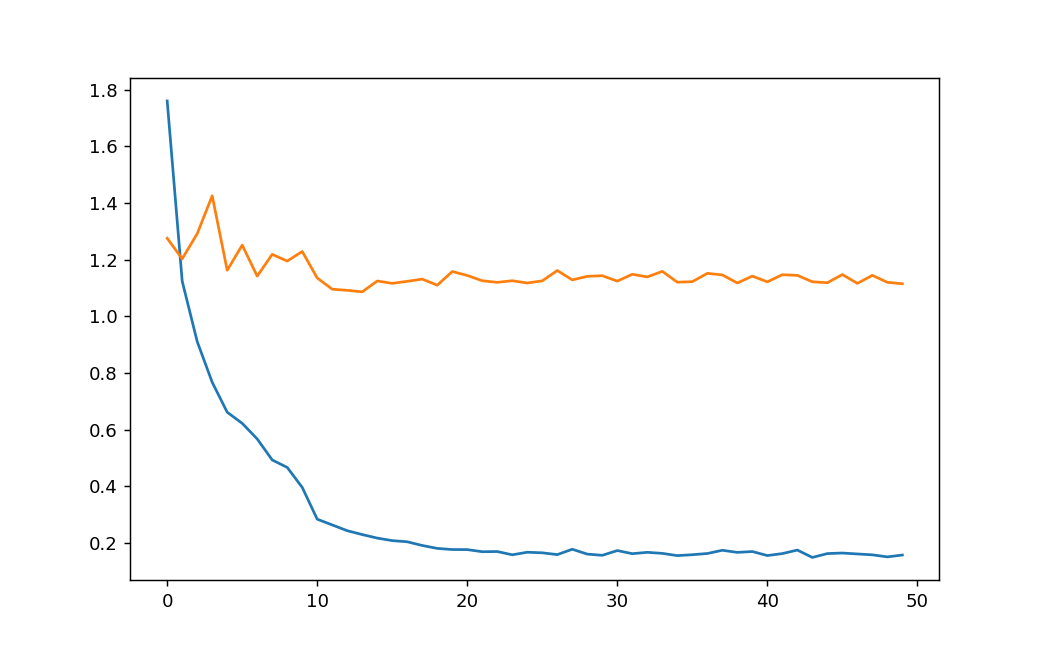

==> Epoch 1/50
Train batch 10/114	 Loss 2.614081 (2.634313)
Train batch 20/114	 Loss 2.393850 (2.509515)
Train batch 30/114	 Loss 2.073758 (2.405008)
Train batch 40/114	 Loss 1.860711 (2.283497)
Train batch 50/114	 Loss 1.474824 (2.175767)
Train batch 60/114	 Loss 1.524382 (2.079488)
Train batch 70/114	 Loss 1.499822 (1.989113)
Train batch 80/114	 Loss 1.301570 (1.928078)
Train batch 90/114	 Loss 1.241514 (1.867151)
Train batch 100/114	 Loss 1.171878 (1.823661)
Train batch 110/114	 Loss 1.551694 (1.777672)
Test:[  0/111]	Time  0.368( 0.368)	Loss 9.2458e-01(9.2458e-01)	Acc@1 68.750(68.750)	Acc@5 93.750(93.750)	Acc@10 100.000(100.000)
Test:[ 10/111]	Time  0.015( 0.049)	Loss 1.6017e+00(1.4286e+00)	Acc@1 62.500(56.250)	Acc@5 81.250(87.500)	Acc@10 93.750(97.727)
Test:[ 20/111]	Time  0.017( 0.034)	Loss 1.3367e+00(1.4812e+00)	Acc@1 37.500(54.167)	Acc@5 93.750(87.798)	Acc@10 100.000(98.214)
Test:[ 30/111]	Time  0.016( 0.029)	Loss 1.5511e+00(1.3615e+00)	Acc@1 43.750(57.460)	Acc@5 87.500(90.927)

 * Acc@1 56.514 Acc@5 94.416 Acc@10 99.718
==> Epoch 5/50
Train batch 10/114	 Loss 0.818161 (0.713892)
Train batch 20/114	 Loss 0.492369 (0.684690)
Train batch 30/114	 Loss 0.580537 (0.660067)
Train batch 40/114	 Loss 0.584580 (0.652482)
Train batch 50/114	 Loss 0.838766 (0.672211)
Train batch 60/114	 Loss 0.651043 (0.660431)
Train batch 70/114	 Loss 0.491599 (0.662291)
Train batch 80/114	 Loss 1.045097 (0.664166)
Train batch 90/114	 Loss 0.648514 (0.664685)
Train batch 100/114	 Loss 0.724160 (0.668273)
Train batch 110/114	 Loss 0.446526 (0.659686)
Test:[  0/111]	Time  0.394( 0.394)	Loss 6.6768e-01(6.6768e-01)	Acc@1 75.000(75.000)	Acc@5 93.750(93.750)	Acc@10 100.000(100.000)
Test:[ 10/111]	Time  0.016( 0.052)	Loss 7.4445e-01(1.0307e+00)	Acc@1 75.000(67.614)	Acc@5 93.750(94.318)	Acc@10 100.000(99.432)
Test:[ 20/111]	Time  0.017( 0.035)	Loss 6.7094e-01(9.4507e-01)	Acc@1 81.250(69.345)	Acc@5 93.750(95.238)	Acc@10 100.000(99.702)
Test:[ 30/111]	Time  0.017( 0.029)	Loss 1.4563e+00(9.0571e-0

Test:[110/111]	Time  0.015( 0.021)	Loss 1.2792e+00(1.2190e+00)	Acc@1 61.538(65.539)	Acc@5 92.308(96.560)	Acc@10 100.000(99.831)
 * Acc@1 65.539 Acc@5 96.560 Acc@10 99.831
==> Epoch 9/50
Train batch 10/114	 Loss 0.352060 (0.429228)
Train batch 20/114	 Loss 0.445652 (0.453391)
Train batch 30/114	 Loss 0.352851 (0.448280)
Train batch 40/114	 Loss 0.317152 (0.446546)
Train batch 50/114	 Loss 0.685493 (0.446523)
Train batch 60/114	 Loss 0.438678 (0.451968)
Train batch 70/114	 Loss 0.736451 (0.453103)
Train batch 80/114	 Loss 0.371851 (0.453090)
Train batch 90/114	 Loss 0.561013 (0.455438)
Train batch 100/114	 Loss 0.438904 (0.461941)
Train batch 110/114	 Loss 0.736062 (0.471092)
Test:[  0/111]	Time  0.373( 0.373)	Loss 6.6319e-01(6.6319e-01)	Acc@1 75.000(75.000)	Acc@5 100.000(100.000)	Acc@10 100.000(100.000)
Test:[ 10/111]	Time  0.020( 0.055)	Loss 4.4328e-01(1.0966e+00)	Acc@1 81.250(68.750)	Acc@5 100.000(97.159)	Acc@10 100.000(100.000)
Test:[ 20/111]	Time  0.021( 0.039)	Loss 4.9605e-01(9.838

Test:[100/111]	Time  0.017( 0.021)	Loss 6.0795e-01(1.1194e+00)	Acc@1 75.000(68.255)	Acc@5 93.750(97.153)	Acc@10 100.000(99.814)
Test:[110/111]	Time  0.014( 0.020)	Loss 8.8485e-01(1.0960e+00)	Acc@1 84.615(68.923)	Acc@5 100.000(97.236)	Acc@10 100.000(99.831)
 * Acc@1 68.923 Acc@5 97.236 Acc@10 99.831
==> Epoch 13/50
Train batch 10/114	 Loss 0.231022 (0.235549)
Train batch 20/114	 Loss 0.159942 (0.231396)
Train batch 30/114	 Loss 0.218721 (0.245045)
Train batch 40/114	 Loss 0.281999 (0.246609)
Train batch 50/114	 Loss 0.276017 (0.247857)
Train batch 60/114	 Loss 0.393934 (0.242271)
Train batch 70/114	 Loss 0.299922 (0.245812)
Train batch 80/114	 Loss 0.298438 (0.242180)
Train batch 90/114	 Loss 0.291131 (0.245198)
Train batch 100/114	 Loss 0.469945 (0.244538)
Train batch 110/114	 Loss 0.246658 (0.243559)
Test:[  0/111]	Time  0.373( 0.373)	Loss 3.7664e-01(3.7664e-01)	Acc@1 81.250(81.250)	Acc@5 100.000(100.000)	Acc@10 100.000(100.000)
Test:[ 10/111]	Time  0.026( 0.055)	Loss 6.0253e-01(9.663

Test:[100/111]	Time  0.017( 0.021)	Loss 6.3793e-01(1.1416e+00)	Acc@1 75.000(67.760)	Acc@5 93.750(96.968)	Acc@10 100.000(99.876)
Test:[110/111]	Time  0.014( 0.020)	Loss 9.2904e-01(1.1166e+00)	Acc@1 84.615(68.472)	Acc@5 100.000(97.067)	Acc@10 100.000(99.887)
 * Acc@1 68.472 Acc@5 97.067 Acc@10 99.887
==> Epoch 17/50
Train batch 10/114	 Loss 0.140253 (0.220965)
Train batch 20/114	 Loss 0.142990 (0.213358)
Train batch 30/114	 Loss 0.192316 (0.207154)
Train batch 40/114	 Loss 0.281548 (0.218125)
Train batch 50/114	 Loss 0.130939 (0.212945)
Train batch 60/114	 Loss 0.173080 (0.212337)
Train batch 70/114	 Loss 0.123594 (0.210099)
Train batch 80/114	 Loss 0.110175 (0.206031)
Train batch 90/114	 Loss 0.276869 (0.207694)
Train batch 100/114	 Loss 0.168160 (0.206632)
Train batch 110/114	 Loss 0.117840 (0.205871)
Test:[  0/111]	Time  0.382( 0.382)	Loss 3.5752e-01(3.5752e-01)	Acc@1 87.500(87.500)	Acc@5 100.000(100.000)	Acc@10 100.000(100.000)
Test:[ 10/111]	Time  0.016( 0.054)	Loss 5.2869e-01(9.288

Test:[100/111]	Time  0.017( 0.022)	Loss 6.6392e-01(1.1840e+00)	Acc@1 75.000(66.770)	Acc@5 93.750(97.215)	Acc@10 100.000(99.876)
Test:[110/111]	Time  0.014( 0.022)	Loss 8.7784e-01(1.1583e+00)	Acc@1 84.615(67.456)	Acc@5 100.000(97.236)	Acc@10 100.000(99.887)
 * Acc@1 67.456 Acc@5 97.236 Acc@10 99.887
==> Epoch 21/50
Train batch 10/114	 Loss 0.168876 (0.134852)
Train batch 20/114	 Loss 0.159126 (0.162005)
Train batch 30/114	 Loss 0.178532 (0.153583)
Train batch 40/114	 Loss 0.123084 (0.164577)
Train batch 50/114	 Loss 0.215606 (0.157895)
Train batch 60/114	 Loss 0.132427 (0.165134)
Train batch 70/114	 Loss 0.343288 (0.171129)
Train batch 80/114	 Loss 0.238516 (0.172348)
Train batch 90/114	 Loss 0.069037 (0.172490)
Train batch 100/114	 Loss 0.221852 (0.170436)
Train batch 110/114	 Loss 0.258876 (0.174134)
Test:[  0/111]	Time  0.374( 0.374)	Loss 3.7009e-01(3.7009e-01)	Acc@1 87.500(87.500)	Acc@5 100.000(100.000)	Acc@10 100.000(100.000)
Test:[ 10/111]	Time  0.021( 0.053)	Loss 5.8212e-01(9.532

Test:[100/111]	Time  0.018( 0.021)	Loss 6.1630e-01(1.1502e+00)	Acc@1 81.250(67.822)	Acc@5 93.750(97.277)	Acc@10 100.000(99.876)
Test:[110/111]	Time  0.014( 0.020)	Loss 8.7139e-01(1.1259e+00)	Acc@1 84.615(68.528)	Acc@5 100.000(97.293)	Acc@10 100.000(99.887)
 * Acc@1 68.528 Acc@5 97.293 Acc@10 99.887
==> Epoch 25/50
Train batch 10/114	 Loss 0.197106 (0.162942)
Train batch 20/114	 Loss 0.185896 (0.176242)
Train batch 30/114	 Loss 0.113896 (0.167144)
Train batch 40/114	 Loss 0.104373 (0.160123)
Train batch 50/114	 Loss 0.201662 (0.159361)
Train batch 60/114	 Loss 0.204050 (0.165972)
Train batch 70/114	 Loss 0.170458 (0.167471)
Train batch 80/114	 Loss 0.151905 (0.168266)
Train batch 90/114	 Loss 0.130235 (0.166192)
Train batch 100/114	 Loss 0.096818 (0.168500)
Train batch 110/114	 Loss 0.065061 (0.167869)
Test:[  0/111]	Time  0.377( 0.377)	Loss 3.6472e-01(3.6472e-01)	Acc@1 87.500(87.500)	Acc@5 100.000(100.000)	Acc@10 100.000(100.000)
Test:[ 10/111]	Time  0.018( 0.054)	Loss 5.7968e-01(9.469

Test:[100/111]	Time  0.016( 0.021)	Loss 6.5567e-01(1.1496e+00)	Acc@1 75.000(67.698)	Acc@5 93.750(97.277)	Acc@10 100.000(99.814)
Test:[110/111]	Time  0.014( 0.020)	Loss 9.6478e-01(1.1288e+00)	Acc@1 84.615(68.302)	Acc@5 100.000(97.349)	Acc@10 100.000(99.831)
 * Acc@1 68.302 Acc@5 97.349 Acc@10 99.831
==> Epoch 29/50
Train batch 10/114	 Loss 0.176044 (0.168897)
Train batch 20/114	 Loss 0.128554 (0.171244)
Train batch 30/114	 Loss 0.147253 (0.166803)
Train batch 40/114	 Loss 0.164562 (0.164517)
Train batch 50/114	 Loss 0.199234 (0.156792)
Train batch 60/114	 Loss 0.205624 (0.159656)
Train batch 70/114	 Loss 0.093841 (0.159476)
Train batch 80/114	 Loss 0.086737 (0.158319)
Train batch 90/114	 Loss 0.115080 (0.158607)
Train batch 100/114	 Loss 0.185516 (0.158921)
Train batch 110/114	 Loss 0.150614 (0.161282)
Test:[  0/111]	Time  0.364( 0.364)	Loss 3.8959e-01(3.8959e-01)	Acc@1 75.000(75.000)	Acc@5 100.000(100.000)	Acc@10 100.000(100.000)
Test:[ 10/111]	Time  0.016( 0.049)	Loss 5.6606e-01(9.283

Test:[ 90/111]	Time  0.018( 0.026)	Loss 2.0580e+00(1.2167e+00)	Acc@1 50.000(66.071)	Acc@5 93.750(96.909)	Acc@10 100.000(99.863)
Test:[100/111]	Time  0.015( 0.025)	Loss 5.9243e-01(1.1783e+00)	Acc@1 81.250(66.894)	Acc@5 93.750(97.092)	Acc@10 100.000(99.876)
Test:[110/111]	Time  0.014( 0.024)	Loss 8.2892e-01(1.1486e+00)	Acc@1 92.308(67.682)	Acc@5 100.000(97.124)	Acc@10 100.000(99.887)
 * Acc@1 67.682 Acc@5 97.124 Acc@10 99.887
==> Epoch 33/50
Train batch 10/114	 Loss 0.340916 (0.202922)
Train batch 20/114	 Loss 0.160778 (0.186756)
Train batch 30/114	 Loss 0.127066 (0.174381)
Train batch 40/114	 Loss 0.118042 (0.175137)
Train batch 50/114	 Loss 0.152713 (0.172406)
Train batch 60/114	 Loss 0.156902 (0.173073)
Train batch 70/114	 Loss 0.144736 (0.168472)
Train batch 80/114	 Loss 0.268699 (0.170219)
Train batch 90/114	 Loss 0.099864 (0.168802)
Train batch 100/114	 Loss 0.065648 (0.167154)
Train batch 110/114	 Loss 0.081419 (0.167279)
Test:[  0/111]	Time  0.400( 0.400)	Loss 3.4410e-01(3.4410e-

Test:[ 80/111]	Time  0.024( 0.023)	Loss 6.4726e-01(1.1773e+00)	Acc@1 75.000(66.898)	Acc@5 100.000(97.145)	Acc@10 100.000(99.846)
Test:[ 90/111]	Time  0.017( 0.022)	Loss 2.0045e+00(1.1808e+00)	Acc@1 50.000(66.690)	Acc@5 93.750(97.047)	Acc@10 100.000(99.863)
Test:[100/111]	Time  0.019( 0.022)	Loss 6.4286e-01(1.1474e+00)	Acc@1 75.000(67.265)	Acc@5 93.750(97.153)	Acc@10 100.000(99.876)
Test:[110/111]	Time  0.013( 0.021)	Loss 8.9618e-01(1.1226e+00)	Acc@1 84.615(68.020)	Acc@5 100.000(97.180)	Acc@10 100.000(99.887)
 * Acc@1 68.020 Acc@5 97.180 Acc@10 99.887
==> Epoch 37/50
Train batch 10/114	 Loss 0.175597 (0.169769)
Train batch 20/114	 Loss 0.147482 (0.164541)
Train batch 30/114	 Loss 0.217273 (0.162416)
Train batch 40/114	 Loss 0.157410 (0.157901)
Train batch 50/114	 Loss 0.178389 (0.161275)
Train batch 60/114	 Loss 0.096713 (0.158766)
Train batch 70/114	 Loss 0.322637 (0.160012)
Train batch 80/114	 Loss 0.070825 (0.158935)
Train batch 90/114	 Loss 0.152939 (0.157666)
Train batch 100/114	 L

Test:[ 80/111]	Time  0.016( 0.022)	Loss 7.0355e-01(1.1954e+00)	Acc@1 68.750(67.052)	Acc@5 100.000(97.299)	Acc@10 100.000(99.846)
Test:[ 90/111]	Time  0.016( 0.021)	Loss 2.0156e+00(1.1982e+00)	Acc@1 50.000(66.621)	Acc@5 93.750(97.184)	Acc@10 100.000(99.863)
Test:[100/111]	Time  0.016( 0.021)	Loss 6.3584e-01(1.1650e+00)	Acc@1 81.250(67.079)	Acc@5 93.750(97.277)	Acc@10 100.000(99.876)
Test:[110/111]	Time  0.014( 0.020)	Loss 8.9403e-01(1.1422e+00)	Acc@1 84.615(67.795)	Acc@5 100.000(97.293)	Acc@10 100.000(99.887)
 * Acc@1 67.795 Acc@5 97.293 Acc@10 99.887
==> Epoch 41/50
Train batch 10/114	 Loss 0.111016 (0.133373)
Train batch 20/114	 Loss 0.050654 (0.131158)
Train batch 30/114	 Loss 0.127605 (0.150246)
Train batch 40/114	 Loss 0.164312 (0.152652)
Train batch 50/114	 Loss 0.197452 (0.148657)
Train batch 60/114	 Loss 0.104503 (0.149930)
Train batch 70/114	 Loss 0.272290 (0.155544)
Train batch 80/114	 Loss 0.099754 (0.155134)
Train batch 90/114	 Loss 0.066543 (0.156939)
Train batch 100/114	 L

Test:[ 80/111]	Time  0.017( 0.022)	Loss 7.2375e-01(1.1770e+00)	Acc@1 75.000(67.207)	Acc@5 100.000(97.454)	Acc@10 100.000(99.846)
Test:[ 90/111]	Time  0.017( 0.021)	Loss 1.9265e+00(1.1783e+00)	Acc@1 50.000(66.896)	Acc@5 93.750(97.321)	Acc@10 100.000(99.863)
Test:[100/111]	Time  0.016( 0.021)	Loss 6.2679e-01(1.1445e+00)	Acc@1 81.250(67.574)	Acc@5 93.750(97.401)	Acc@10 100.000(99.876)
Test:[110/111]	Time  0.014( 0.020)	Loss 9.1604e-01(1.1222e+00)	Acc@1 84.615(68.415)	Acc@5 100.000(97.406)	Acc@10 100.000(99.887)
 * Acc@1 68.415 Acc@5 97.406 Acc@10 99.887
==> Epoch 45/50
Train batch 10/114	 Loss 0.077733 (0.162926)
Train batch 20/114	 Loss 0.094691 (0.158102)
Train batch 30/114	 Loss 0.230705 (0.176646)
Train batch 40/114	 Loss 0.109084 (0.182601)
Train batch 50/114	 Loss 0.255588 (0.179346)
Train batch 60/114	 Loss 0.092439 (0.175181)
Train batch 70/114	 Loss 0.219737 (0.174022)
Train batch 80/114	 Loss 0.149047 (0.169347)
Train batch 90/114	 Loss 0.119314 (0.168757)
Train batch 100/114	 L

Test:[ 80/111]	Time  0.016( 0.028)	Loss 6.9482e-01(1.1916e+00)	Acc@1 75.000(67.361)	Acc@5 100.000(97.299)	Acc@10 100.000(99.846)
Test:[ 90/111]	Time  0.017( 0.026)	Loss 2.0024e+00(1.1950e+00)	Acc@1 56.250(66.758)	Acc@5 93.750(97.184)	Acc@10 100.000(99.863)
Test:[100/111]	Time  0.017( 0.025)	Loss 6.5674e-01(1.1653e+00)	Acc@1 75.000(67.327)	Acc@5 93.750(97.277)	Acc@10 100.000(99.876)
Test:[110/111]	Time  0.013( 0.025)	Loss 9.5368e-01(1.1448e+00)	Acc@1 84.615(68.077)	Acc@5 100.000(97.293)	Acc@10 100.000(99.887)
 * Acc@1 68.077 Acc@5 97.293 Acc@10 99.887
==> Epoch 49/50
Train batch 10/114	 Loss 0.146945 (0.124209)
Train batch 20/114	 Loss 0.083517 (0.148759)
Train batch 30/114	 Loss 0.124503 (0.148326)
Train batch 40/114	 Loss 0.152655 (0.146327)
Train batch 50/114	 Loss 0.108450 (0.154078)
Train batch 60/114	 Loss 0.240369 (0.152546)
Train batch 70/114	 Loss 0.143747 (0.146812)
Train batch 80/114	 Loss 0.169703 (0.147089)
Train batch 90/114	 Loss 0.095831 (0.150143)
Train batch 100/114	 L

train_loss,█▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▃▅█▄▂▄▃▂▁▁▁▂▂▂▁▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
val_top1,▁▂▂▁▄▆▆▆▇████▇███▇██▇▇█▇▇▇▇███████▇█▇▇██
val_top10,▁▃▅▅▅▅▆█▇▆▆▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇
val_top5,▁▅▅▃▆▆▆▆▇▇██▇████▇█▇█▇█▇█▇▇▇▇▇▇███▇█▇█▇█
The best acc:,68.92273
train_loss,0.15766
val_loss,1.11522
val_top1,68.30231
val_top10,99.8872
val_top5,97.51833


train item: 3621
Test item: 1776
Initializing model: resnet18
Model size: 11.18267M


<IPython.core.display.Javascript object>


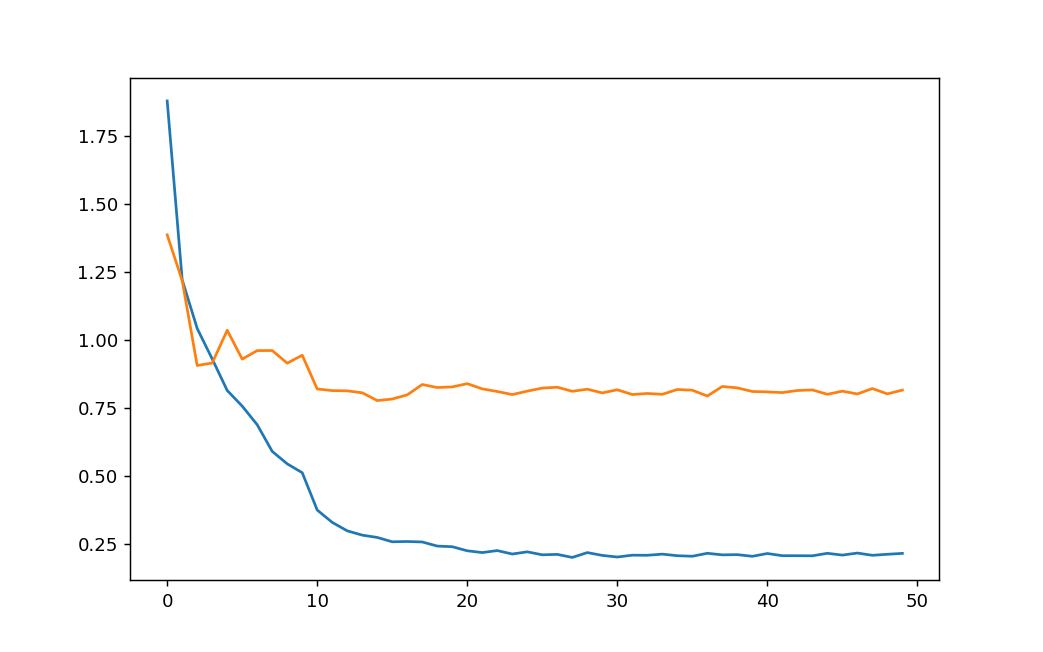

==> Epoch 1/50
Train batch 10/114	 Loss 2.579704 (2.601004)
Train batch 20/114	 Loss 2.393920 (2.548962)
Train batch 30/114	 Loss 2.317295 (2.471933)
Train batch 40/114	 Loss 1.963959 (2.373781)
Train batch 50/114	 Loss 1.668741 (2.256603)
Train batch 60/114	 Loss 2.002438 (2.182398)
Train batch 70/114	 Loss 1.833146 (2.101236)
Train batch 80/114	 Loss 1.650493 (2.040536)
Train batch 90/114	 Loss 1.441799 (1.982725)
Train batch 100/114	 Loss 1.493394 (1.937842)
Train batch 110/114	 Loss 1.133316 (1.894149)
Test:[  0/111]	Time  0.407( 0.407)	Loss 1.1663e+00(1.1663e+00)	Acc@1 50.000(50.000)	Acc@5 93.750(93.750)	Acc@10 100.000(100.000)
Test:[ 10/111]	Time  0.015( 0.054)	Loss 1.5520e+00(1.4152e+00)	Acc@1 43.750(40.341)	Acc@5 93.750(93.750)	Acc@10 100.000(100.000)
Test:[ 20/111]	Time  0.018( 0.038)	Loss 1.1290e+00(1.3407e+00)	Acc@1 56.250(45.833)	Acc@5 93.750(94.940)	Acc@10 100.000(99.702)
Test:[ 30/111]	Time  0.017( 0.031)	Loss 1.3576e+00(1.5195e+00)	Acc@1 43.750(42.339)	Acc@5 87.500(91.53

Test:[110/111]	Time  0.015( 0.022)	Loss 5.2108e-01(9.1642e-01)	Acc@1 75.000(69.482)	Acc@5 100.000(96.734)	Acc@10 100.000(99.550)
 * Acc@1 69.482 Acc@5 96.734 Acc@10 99.550
==> Epoch 5/50
Train batch 10/114	 Loss 1.185172 (0.813443)
Train batch 20/114	 Loss 0.772424 (0.807936)
Train batch 30/114	 Loss 0.785196 (0.806902)
Train batch 40/114	 Loss 0.975668 (0.792087)
Train batch 50/114	 Loss 1.044161 (0.809165)
Train batch 60/114	 Loss 0.556450 (0.800291)
Train batch 70/114	 Loss 0.683679 (0.797039)
Train batch 80/114	 Loss 1.119079 (0.801455)
Train batch 90/114	 Loss 0.853849 (0.819335)
Train batch 100/114	 Loss 1.341436 (0.818969)
Train batch 110/114	 Loss 0.828451 (0.819060)
Test:[  0/111]	Time  0.411( 0.411)	Loss 1.0908e+00(1.0908e+00)	Acc@1 75.000(75.000)	Acc@5 93.750(93.750)	Acc@10 100.000(100.000)
Test:[ 10/111]	Time  0.018( 0.060)	Loss 4.6491e-01(1.0834e+00)	Acc@1 93.750(65.909)	Acc@5 100.000(96.023)	Acc@10 100.000(100.000)
Test:[ 20/111]	Time  0.024( 0.042)	Loss 6.5936e-01(9.6344

Test:[100/111]	Time  0.016( 0.022)	Loss 7.1839e-01(9.6310e-01)	Acc@1 68.750(67.017)	Acc@5 100.000(97.525)	Acc@10 100.000(99.691)
Test:[110/111]	Time  0.015( 0.021)	Loss 7.7724e-01(9.6220e-01)	Acc@1 68.750(67.624)	Acc@5 100.000(97.466)	Acc@10 100.000(99.662)
 * Acc@1 67.624 Acc@5 97.466 Acc@10 99.662
==> Epoch 9/50
Train batch 10/114	 Loss 0.441516 (0.525467)
Train batch 20/114	 Loss 0.572741 (0.539759)
Train batch 30/114	 Loss 0.229913 (0.529364)
Train batch 40/114	 Loss 0.579681 (0.554678)
Train batch 50/114	 Loss 0.589537 (0.566242)
Train batch 60/114	 Loss 0.539162 (0.564727)
Train batch 70/114	 Loss 0.445873 (0.561483)
Train batch 80/114	 Loss 0.604213 (0.545297)
Train batch 90/114	 Loss 0.448794 (0.545283)
Train batch 100/114	 Loss 1.008414 (0.550224)
Train batch 110/114	 Loss 0.632970 (0.544667)
Test:[  0/111]	Time  0.379( 0.379)	Loss 8.2087e-01(8.2087e-01)	Acc@1 81.250(81.250)	Acc@5 93.750(93.750)	Acc@10 100.000(100.000)
Test:[ 10/111]	Time  0.020( 0.054)	Loss 4.1832e-01(8.7857e

Test:[100/111]	Time  0.016( 0.022)	Loss 4.4119e-01(8.1799e-01)	Acc@1 81.250(74.134)	Acc@5 100.000(97.896)	Acc@10 100.000(99.814)
Test:[110/111]	Time  0.018( 0.022)	Loss 7.5960e-01(8.1514e-01)	Acc@1 75.000(74.437)	Acc@5 100.000(97.804)	Acc@10 100.000(99.775)
 * Acc@1 74.437 Acc@5 97.804 Acc@10 99.775
==> Epoch 13/50
Train batch 10/114	 Loss 0.311874 (0.263459)
Train batch 20/114	 Loss 0.175309 (0.277459)
Train batch 30/114	 Loss 0.279684 (0.299128)
Train batch 40/114	 Loss 0.331679 (0.296571)
Train batch 50/114	 Loss 0.344433 (0.308769)
Train batch 60/114	 Loss 0.187928 (0.305152)
Train batch 70/114	 Loss 0.295217 (0.305440)
Train batch 80/114	 Loss 0.333734 (0.298612)
Train batch 90/114	 Loss 0.170352 (0.300082)
Train batch 100/114	 Loss 0.379208 (0.301163)
Train batch 110/114	 Loss 0.225322 (0.300442)
Test:[  0/111]	Time  0.383( 0.383)	Loss 6.3997e-01(6.3997e-01)	Acc@1 75.000(75.000)	Acc@5 100.000(100.000)	Acc@10 100.000(100.000)
Test:[ 10/111]	Time  0.016( 0.054)	Loss 2.2367e-01(9.50

Test:[ 90/111]	Time  0.015( 0.028)	Loss 6.5120e-01(7.7177e-01)	Acc@1 81.250(74.931)	Acc@5 100.000(97.802)	Acc@10 100.000(99.794)
Test:[100/111]	Time  0.018( 0.027)	Loss 5.3008e-01(7.8308e-01)	Acc@1 81.250(74.814)	Acc@5 100.000(97.834)	Acc@10 100.000(99.814)
Test:[110/111]	Time  0.015( 0.026)	Loss 7.7702e-01(7.8410e-01)	Acc@1 75.000(74.831)	Acc@5 100.000(97.748)	Acc@10 100.000(99.775)
 * Acc@1 74.831 Acc@5 97.748 Acc@10 99.775
==> Epoch 17/50
Train batch 10/114	 Loss 0.219280 (0.269960)
Train batch 20/114	 Loss 0.207054 (0.276870)
Train batch 30/114	 Loss 0.291993 (0.269921)
Train batch 40/114	 Loss 0.228852 (0.268260)
Train batch 50/114	 Loss 0.264070 (0.272152)
Train batch 60/114	 Loss 0.265823 (0.268120)
Train batch 70/114	 Loss 0.292598 (0.263148)
Train batch 80/114	 Loss 0.208069 (0.263845)
Train batch 90/114	 Loss 0.195621 (0.262714)
Train batch 100/114	 Loss 0.143583 (0.260061)
Train batch 110/114	 Loss 0.342783 (0.261827)
Test:[  0/111]	Time  0.377( 0.377)	Loss 6.3611e-01(6.3611

Test:[ 80/111]	Time  0.016( 0.021)	Loss 4.3669e-01(8.2237e-01)	Acc@1 81.250(74.691)	Acc@5 100.000(97.994)	Acc@10 100.000(99.691)
Test:[ 90/111]	Time  0.017( 0.021)	Loss 7.3774e-01(8.0554e-01)	Acc@1 81.250(75.000)	Acc@5 100.000(98.077)	Acc@10 100.000(99.725)
Test:[100/111]	Time  0.016( 0.020)	Loss 5.5466e-01(8.2336e-01)	Acc@1 75.000(74.319)	Acc@5 100.000(98.082)	Acc@10 100.000(99.752)
Test:[110/111]	Time  0.014( 0.020)	Loss 9.4004e-01(8.2864e-01)	Acc@1 75.000(74.212)	Acc@5 100.000(97.917)	Acc@10 100.000(99.718)
 * Acc@1 74.212 Acc@5 97.917 Acc@10 99.718
==> Epoch 21/50
Train batch 10/114	 Loss 0.368400 (0.273882)
Train batch 20/114	 Loss 0.084342 (0.227667)
Train batch 30/114	 Loss 0.306818 (0.222227)
Train batch 40/114	 Loss 0.383188 (0.223958)
Train batch 50/114	 Loss 0.109101 (0.219043)
Train batch 60/114	 Loss 0.338625 (0.219883)
Train batch 70/114	 Loss 0.275649 (0.223646)
Train batch 80/114	 Loss 0.265166 (0.225625)
Train batch 90/114	 Loss 0.348997 (0.226603)
Train batch 100/114	

Test:[ 80/111]	Time  0.016( 0.021)	Loss 4.1361e-01(7.9409e-01)	Acc@1 81.250(75.154)	Acc@5 100.000(97.840)	Acc@10 100.000(99.691)
Test:[ 90/111]	Time  0.016( 0.021)	Loss 6.7550e-01(7.7781e-01)	Acc@1 81.250(75.412)	Acc@5 100.000(97.940)	Acc@10 100.000(99.725)
Test:[100/111]	Time  0.017( 0.020)	Loss 5.5150e-01(7.9592e-01)	Acc@1 75.000(74.938)	Acc@5 100.000(98.020)	Acc@10 100.000(99.752)
Test:[110/111]	Time  0.014( 0.020)	Loss 8.6599e-01(8.0053e-01)	Acc@1 75.000(74.775)	Acc@5 100.000(97.917)	Acc@10 100.000(99.718)
 * Acc@1 74.775 Acc@5 97.917 Acc@10 99.718
==> Epoch 25/50
Train batch 10/114	 Loss 0.189785 (0.217715)
Train batch 20/114	 Loss 0.217546 (0.222351)
Train batch 30/114	 Loss 0.282048 (0.219228)
Train batch 40/114	 Loss 0.146672 (0.223434)
Train batch 50/114	 Loss 0.179882 (0.226163)
Train batch 60/114	 Loss 0.300808 (0.221802)
Train batch 70/114	 Loss 0.192582 (0.220997)
Train batch 80/114	 Loss 0.189402 (0.218615)
Train batch 90/114	 Loss 0.156321 (0.217831)
Train batch 100/114	

Test:[ 80/111]	Time  0.018( 0.022)	Loss 3.8715e-01(8.0918e-01)	Acc@1 81.250(74.923)	Acc@5 100.000(97.454)	Acc@10 100.000(99.691)
Test:[ 90/111]	Time  0.017( 0.022)	Loss 7.1848e-01(7.8925e-01)	Acc@1 81.250(75.343)	Acc@5 100.000(97.596)	Acc@10 100.000(99.725)
Test:[100/111]	Time  0.022( 0.021)	Loss 5.5483e-01(8.0818e-01)	Acc@1 75.000(74.752)	Acc@5 100.000(97.649)	Acc@10 100.000(99.752)
Test:[110/111]	Time  0.014( 0.021)	Loss 8.7151e-01(8.1257e-01)	Acc@1 75.000(74.775)	Acc@5 100.000(97.523)	Acc@10 100.000(99.718)
 * Acc@1 74.775 Acc@5 97.523 Acc@10 99.718
==> Epoch 29/50
Train batch 10/114	 Loss 0.375409 (0.257651)
Train batch 20/114	 Loss 0.072910 (0.232617)
Train batch 30/114	 Loss 0.304932 (0.236048)
Train batch 40/114	 Loss 0.212697 (0.227170)
Train batch 50/114	 Loss 0.312100 (0.222985)
Train batch 60/114	 Loss 0.316028 (0.225367)
Train batch 70/114	 Loss 0.137861 (0.221951)
Train batch 80/114	 Loss 0.207830 (0.224508)
Train batch 90/114	 Loss 0.206568 (0.218467)
Train batch 100/114	

Test:[ 80/111]	Time  0.016( 0.022)	Loss 3.9906e-01(7.9896e-01)	Acc@1 81.250(75.463)	Acc@5 100.000(97.531)	Acc@10 100.000(99.769)
Test:[ 90/111]	Time  0.017( 0.021)	Loss 6.7806e-01(7.8292e-01)	Acc@1 81.250(75.687)	Acc@5 100.000(97.665)	Acc@10 100.000(99.794)
Test:[100/111]	Time  0.016( 0.021)	Loss 5.4248e-01(7.9678e-01)	Acc@1 81.250(75.433)	Acc@5 100.000(97.772)	Acc@10 100.000(99.814)
Test:[110/111]	Time  0.015( 0.020)	Loss 8.6787e-01(8.0077e-01)	Acc@1 75.000(75.169)	Acc@5 100.000(97.635)	Acc@10 100.000(99.775)
 * Acc@1 75.169 Acc@5 97.635 Acc@10 99.775
==> Epoch 33/50
Train batch 10/114	 Loss 0.388295 (0.257406)
Train batch 20/114	 Loss 0.146384 (0.233583)
Train batch 30/114	 Loss 0.164382 (0.210350)
Train batch 40/114	 Loss 0.177634 (0.217202)
Train batch 50/114	 Loss 0.235105 (0.215935)
Train batch 60/114	 Loss 0.342970 (0.216460)
Train batch 70/114	 Loss 0.194592 (0.212859)
Train batch 80/114	 Loss 0.096514 (0.207715)
Train batch 90/114	 Loss 0.234723 (0.212143)
Train batch 100/114	

Test:[ 70/111]	Time  0.021( 0.023)	Loss 1.2204e+00(8.2553e-01)	Acc@1 56.250(74.120)	Acc@5 100.000(97.359)	Acc@10 100.000(99.648)
Test:[ 80/111]	Time  0.022( 0.023)	Loss 3.5483e-01(8.1666e-01)	Acc@1 87.500(74.151)	Acc@5 100.000(97.454)	Acc@10 100.000(99.691)
Test:[ 90/111]	Time  0.016( 0.022)	Loss 6.9672e-01(7.9795e-01)	Acc@1 81.250(74.588)	Acc@5 100.000(97.596)	Acc@10 100.000(99.725)
Test:[100/111]	Time  0.022( 0.022)	Loss 5.4260e-01(8.1346e-01)	Acc@1 81.250(74.196)	Acc@5 100.000(97.710)	Acc@10 100.000(99.752)
Test:[110/111]	Time  0.015( 0.022)	Loss 8.4809e-01(8.1653e-01)	Acc@1 75.000(74.155)	Acc@5 100.000(97.635)	Acc@10 100.000(99.718)
 * Acc@1 74.155 Acc@5 97.635 Acc@10 99.718
==> Epoch 37/50
Train batch 10/114	 Loss 0.291840 (0.207122)
Train batch 20/114	 Loss 0.175917 (0.206793)
Train batch 30/114	 Loss 0.218106 (0.208339)
Train batch 40/114	 Loss 0.123151 (0.217760)
Train batch 50/114	 Loss 0.274956 (0.222701)
Train batch 60/114	 Loss 0.257911 (0.221471)
Train batch 70/114	 Loss 0

Test:[ 60/111]	Time  0.016( 0.023)	Loss 2.6266e-01(8.7075e-01)	Acc@1 93.750(74.180)	Acc@5 100.000(96.926)	Acc@10 100.000(99.488)
Test:[ 70/111]	Time  0.021( 0.022)	Loss 1.2278e+00(8.2008e-01)	Acc@1 50.000(75.000)	Acc@5 100.000(97.359)	Acc@10 100.000(99.560)
Test:[ 80/111]	Time  0.016( 0.022)	Loss 3.7416e-01(8.0988e-01)	Acc@1 81.250(75.077)	Acc@5 100.000(97.454)	Acc@10 100.000(99.614)
Test:[ 90/111]	Time  0.016( 0.021)	Loss 7.0531e-01(7.9089e-01)	Acc@1 81.250(75.343)	Acc@5 100.000(97.596)	Acc@10 100.000(99.657)
Test:[100/111]	Time  0.017( 0.021)	Loss 5.3798e-01(8.0686e-01)	Acc@1 75.000(74.752)	Acc@5 100.000(97.649)	Acc@10 100.000(99.691)
Test:[110/111]	Time  0.014( 0.020)	Loss 8.8934e-01(8.1182e-01)	Acc@1 68.750(74.493)	Acc@5 100.000(97.466)	Acc@10 100.000(99.662)
 * Acc@1 74.493 Acc@5 97.466 Acc@10 99.662
==> Epoch 41/50
Train batch 10/114	 Loss 0.217066 (0.223118)
Train batch 20/114	 Loss 0.248536 (0.216325)
Train batch 30/114	 Loss 0.187962 (0.211590)
Train batch 40/114	 Loss 0.16268

Test:[ 60/111]	Time  0.016( 0.023)	Loss 2.7504e-01(8.7890e-01)	Acc@1 93.750(73.668)	Acc@5 100.000(97.336)	Acc@10 100.000(99.590)
Test:[ 70/111]	Time  0.016( 0.022)	Loss 1.1936e+00(8.2583e-01)	Acc@1 50.000(74.560)	Acc@5 100.000(97.711)	Acc@10 100.000(99.648)
Test:[ 80/111]	Time  0.017( 0.021)	Loss 3.7989e-01(8.1605e-01)	Acc@1 81.250(74.614)	Acc@5 100.000(97.762)	Acc@10 100.000(99.691)
Test:[ 90/111]	Time  0.016( 0.021)	Loss 6.9940e-01(7.9646e-01)	Acc@1 81.250(74.931)	Acc@5 100.000(97.871)	Acc@10 100.000(99.725)
Test:[100/111]	Time  0.022( 0.021)	Loss 5.2155e-01(8.1100e-01)	Acc@1 81.250(74.691)	Acc@5 100.000(97.896)	Acc@10 100.000(99.752)
Test:[110/111]	Time  0.014( 0.020)	Loss 9.8842e-01(8.1761e-01)	Acc@1 68.750(74.324)	Acc@5 100.000(97.748)	Acc@10 100.000(99.662)
 * Acc@1 74.324 Acc@5 97.748 Acc@10 99.662
==> Epoch 45/50
Train batch 10/114	 Loss 0.338558 (0.231145)
Train batch 20/114	 Loss 0.183855 (0.226626)
Train batch 30/114	 Loss 0.188621 (0.225128)
Train batch 40/114	 Loss 0.19834

Test:[ 50/111]	Time  0.018( 0.025)	Loss 6.7888e-02(8.5422e-01)	Acc@1 100.000(74.877)	Acc@5 100.000(96.446)	Acc@10 100.000(99.632)
Test:[ 60/111]	Time  0.017( 0.024)	Loss 2.7354e-01(8.7775e-01)	Acc@1 93.750(73.463)	Acc@5 100.000(96.926)	Acc@10 100.000(99.590)
Test:[ 70/111]	Time  0.017( 0.023)	Loss 1.2530e+00(8.2744e-01)	Acc@1 50.000(74.384)	Acc@5 100.000(97.359)	Acc@10 100.000(99.648)
Test:[ 80/111]	Time  0.017( 0.022)	Loss 3.5705e-01(8.1705e-01)	Acc@1 81.250(74.460)	Acc@5 100.000(97.454)	Acc@10 100.000(99.691)
Test:[ 90/111]	Time  0.017( 0.022)	Loss 7.1416e-01(7.9907e-01)	Acc@1 81.250(74.931)	Acc@5 100.000(97.596)	Acc@10 100.000(99.725)
Test:[100/111]	Time  0.016( 0.021)	Loss 5.8451e-01(8.1872e-01)	Acc@1 75.000(74.381)	Acc@5 100.000(97.649)	Acc@10 100.000(99.752)
Test:[110/111]	Time  0.015( 0.021)	Loss 8.3753e-01(8.2264e-01)	Acc@1 75.000(74.268)	Acc@5 100.000(97.466)	Acc@10 100.000(99.718)
 * Acc@1 74.268 Acc@5 97.466 Acc@10 99.718
==> Epoch 49/50
Train batch 10/114	 Loss 0.212494 (0.

train_loss,█▅▅▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▂▃▃▃▃▃▁▁▁▁▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_top1,▁▄▆▇▆▆▆▇████████████████████████████████
val_top10,▃▁▆▆█▆▇▇███████▇▇███▇▇██▇██████▇▇██▇███▇
val_top5,▂▁▇▆▆▇▇▇██▇███▇▇▇█▇█▇█▇█▇██████▇██████▇█
The best acc:,75.33784
train_loss,0.21736
val_loss,0.81695
val_top1,74.83109
val_top10,99.66216
val_top5,97.57883


In [15]:
for arch in ['resnet18']: # 'resnet50'  
    for split  in ['split_by_sub', 'split_by_env']: 
        for signal in ['acc']: # 'acc', 'gyr'
            # 🐝 initialise a wandb run
            wandb.init(
                project="Afosr_2022_GAF",
                config={
                    "project":"Afosr_2022_GAF_%s" % (signal),
                    "data_path":"/mnt/works/projectComvis/AFOSR-2020/accelerometer/output/GAF_images_%s" % (signal),
                    "split": split,
                    "train_batch":32,
                    "test_batch":16,
                    "num_classes":12,
                    "workers":4,
                    "weight_decay":5e-04,
                    "momentum":0.9,
                    "lr":0.003,
                    "gamma":0.1,
                    "max_epoch":50,
                    "stepsize":10, # to modify lr
                    "eval_step":1, # 
                    "arch":arch,
                    "print_freq":10,
                    })

            # Copy your config 
            config = wandb.config
            save_dir = os.path.join("./log", config.project,"%s_%s" % (config.arch,config.split))
            #         "train_list":"/home/nhquan/datasets/afosr2022/split_by_subjectid/train.txt",
            #         "test_list": "/home/nhquan/datasets/afosr2022/split_by_subjectid/val.txt",
            train_list=os.path.join("/home/nhquan/datasets/afosr2022",config.split, "train.txt")
            test_list=os.path.join("/home/nhquan/datasets/afosr2022", config.split,"val.txt")

            # torch.manual_seed(100)
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

            scaler = transforms.Resize((224,224))
            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])    


            transform4train= transforms.Compose([
                transforms.RandomRotation(degrees=(-90, 90)),
                scaler,
                transforms.ToTensor(),
                normalize       
                ])   

            transform4test= transforms.Compose([
                scaler,
                transforms.ToTensor(),
                normalize       
                ])     


            # trainDataset = datasets.ImageFolder("./data/data_huy/train/",transform)
            # testDataset=datasets.ImageFolder("./data/data_huy/test/", transform)

            trainDataset = AfosrDataset(config.data_path,train_list,transform=transform4train) 
            print("train item:",trainDataset.__len__())
            testDataset = AfosrDataset(config.data_path,test_list,transform=transform4test) 
            print("Test item:",testDataset.__len__())

            trainLoader = DataLoader(trainDataset, batch_size=config.train_batch, 
                                     shuffle=True, num_workers=config.workers)
            testLoader = DataLoader(testDataset, batch_size=config.test_batch, 
                                    shuffle=False, num_workers=config.workers)


            print("Initializing model: {}".format(config.arch))
            model = models.init_model(name=config.arch, num_classes=config.num_classes)
            print("Model size: {:.5f}M".format(sum(p.numel() for p in model.parameters())/1000000.0))
            model.cuda(device)

            # criterion = nn.CrossEntropyLoss().cuda()
            criterion_xent = criterion = nn.CrossEntropyLoss()

            # optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            optimizer = torch.optim.SGD(model.parameters(), lr=config.lr, 
                                        momentum=config.momentum, weight_decay=config.weight_decay)

            if config.stepsize > 0:
                scheduler = lr_scheduler.StepLR(optimizer, step_size=config.stepsize, gamma=config.gamma)

            ## Train model
            train_loss_values=[]
            test_loss_values=[]
            fig = plt.figure(figsize=(8,5))
            ax = fig.add_subplot(111) # for acce
            fig.show()    
            # ax.set_xlim(left=0, right=len(lines)+10)

            start_time = time.time()
            best_rank1 = -np.inf
            for epoch in range(0, config.max_epoch):
                print("==> Epoch {}/{}".format(epoch+1, config.max_epoch))        
                train_loss=train(model, criterion_xent, optimizer, trainLoader, device).cpu()  
                train_loss_values.append(train_loss)
                if config.stepsize > 0: scheduler.step()
                if (epoch+1)%config.eval_step==0:
                    val_loss,acc1,acc5,acc10= validate(model, criterion_xent,testLoader,device)
                    val_loss=val_loss.cpu()
                    test_loss_values.append(val_loss)
                    if best_rank1<acc1:
                        best_rank1=acc1
                        save_checkpoint({
                            'state_dict': model.state_dict(),
                            'epoch': epoch,
                            }, False, osp.join(save_dir, 'best_checkpoint'  + '.pth.tar'))
                    ax.clear()
                    ax.plot(train_loss_values)
                    ax.plot(test_loss_values)    
                    fig.canvas.draw()  
                    val_log={"train_loss": train_loss, 
                            "val_loss": val_loss,
                            "val_top1":acc1,
                           "val_top5":acc5,
                           "val_top10":acc10}
                wandb.log(val_log)
            print('The best acc: ',best_rank1)
            elapsed = round(time.time() - start_time)
            elapsed = str(datetime.timedelta(seconds=elapsed))
            print("Finished. Total elapsed time (h:m:s): {}".format(elapsed))
            # plt.plot(train_loss_values)
            # plt.plot(test_loss_values)

            wandb.summary['The best acc: '] = best_rank1
            wandb.finish()

# Test model

In [6]:
def plot_confusion_matrix(cm, class_names=None, save_file=None, **kwargs):
    fig = plt.figure(figsize=(10,8 ))
    ax = plt.gca()
    classes = class_names if class_names is not None else np.arange(len(cm))
    heatmap_kwargs = dict(
        vmin=0,
        xticklabels=classes,
        yticklabels=classes,
        annot=True,
        fmt='.2f',
    )
    sn.heatmap(cm,cmap="YlGnBu",
               **{**heatmap_kwargs, **kwargs},
               ax=ax)    
    ax.set_xlabel('Predicted label',fontsize=13) # , fontweight='bold'
    ax.set_ylabel('True label',fontsize=13) # , fontweight='bold'

    if save_file is not None:
        os.makedirs(os.path.dirname(save_file), exist_ok=True)
        plt.savefig(save_file, bbox_inches='tight', transparent=True)
    return fig, ax

class_names=['1', '2 ', '3', '4','5', '6', '7', '8', '9', '10', '11', '12']

Initializing model: resnet18
Model size: 11.18267M
resnet18_split_by_sub_acc: Acc@1 68.923 Acc@5 97.236 Acc@10 99.831


<IPython.core.display.Javascript object>


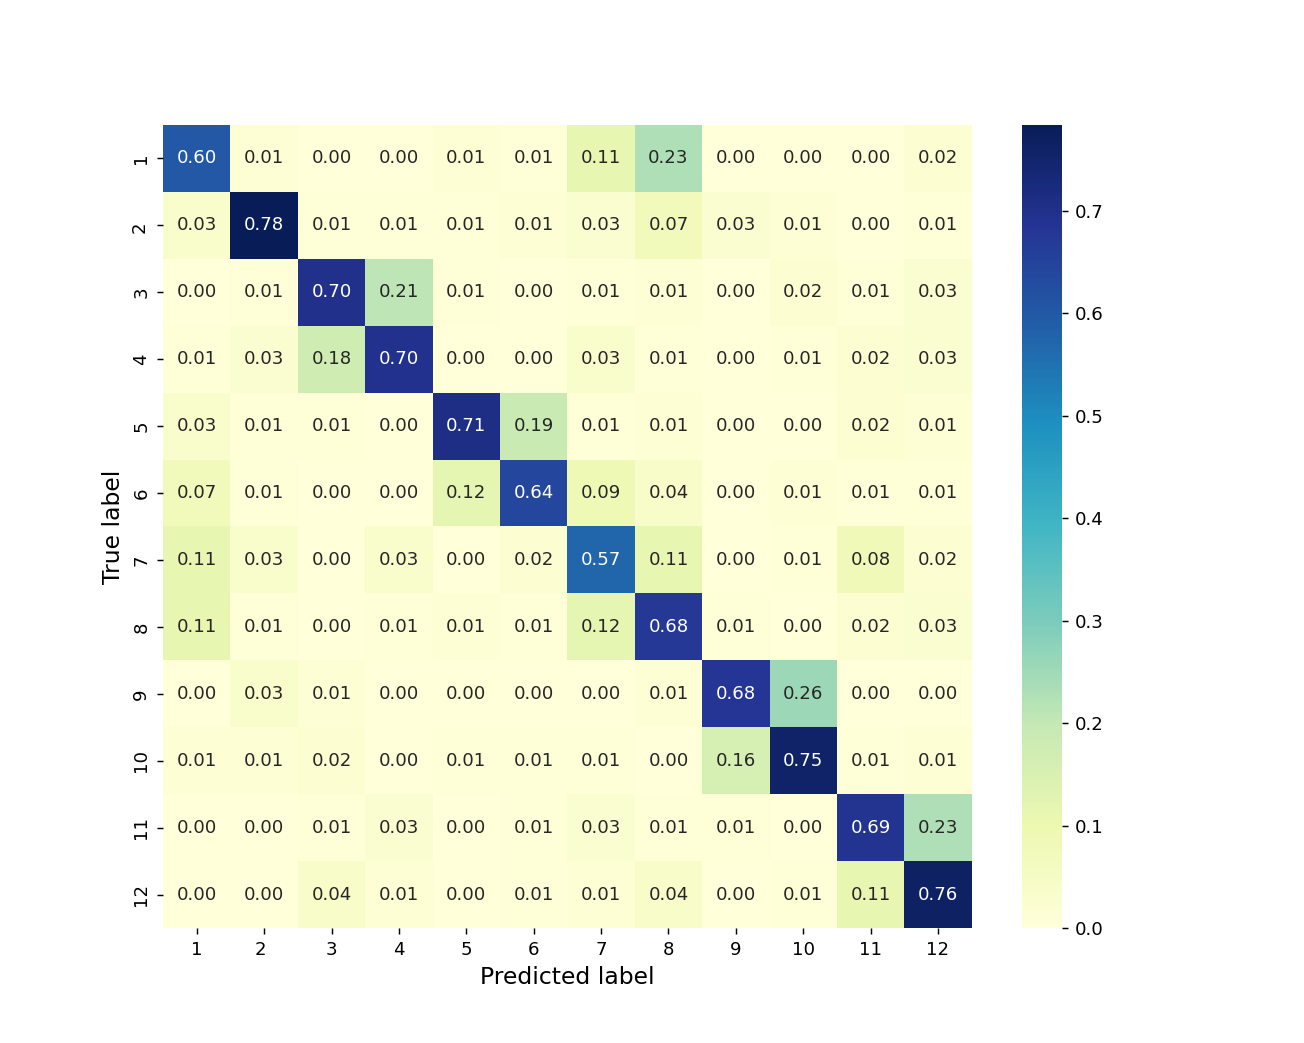

Initializing model: resnet18
Model size: 11.18267M
resnet18_split_by_sub_gyr: Acc@1 70.502 Acc@5 98.421 Acc@10 100.000


<IPython.core.display.Javascript object>


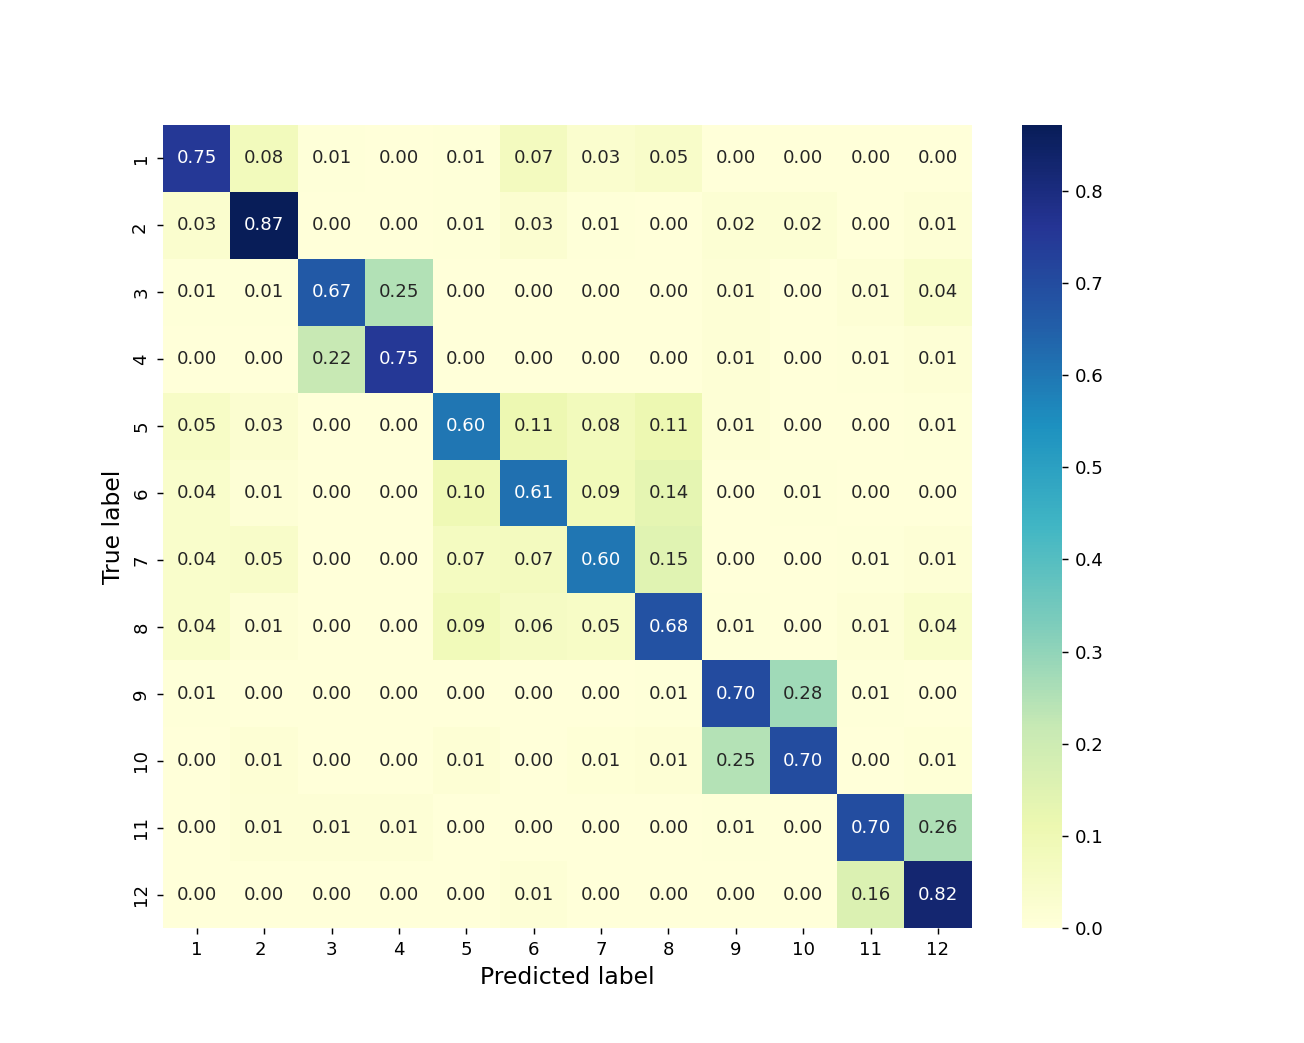

Initializing model: resnet18
Model size: 11.18267M
resnet18_split_by_env_acc: Acc@1 75.338 Acc@5 97.635 Acc@10 99.775


<IPython.core.display.Javascript object>


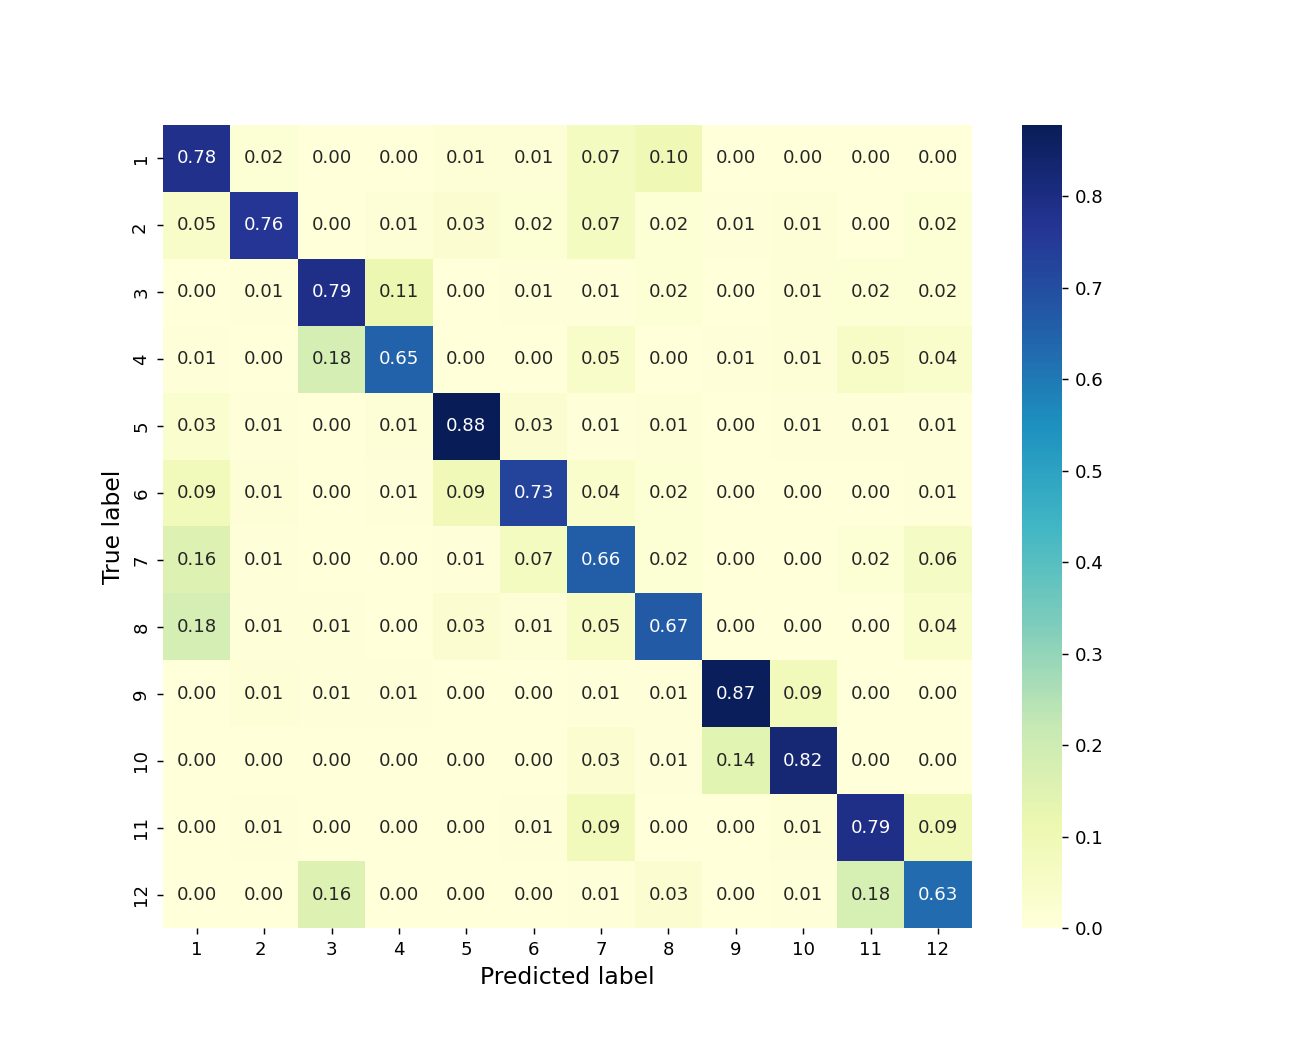

Initializing model: resnet18
Model size: 11.18267M
resnet18_split_by_env_gyr: Acc@1 77.196 Acc@5 98.311 Acc@10 99.887


<IPython.core.display.Javascript object>


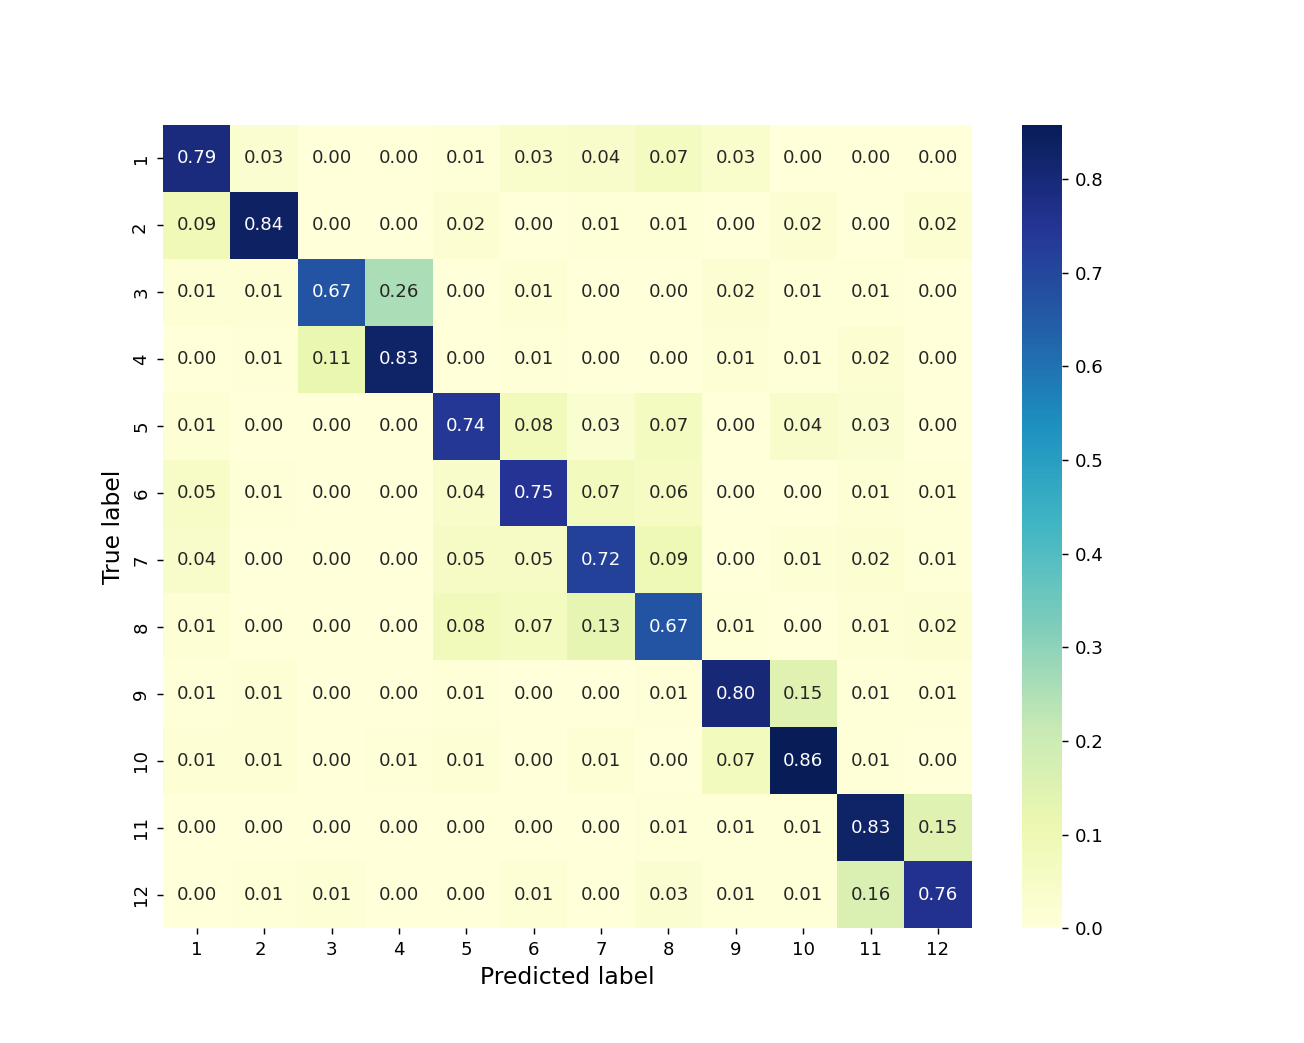

Initializing model: resnet50
Model size: 23.53262M
resnet50_split_by_sub_acc: Acc@1 68.979 Acc@5 97.688 Acc@10 99.774


<IPython.core.display.Javascript object>


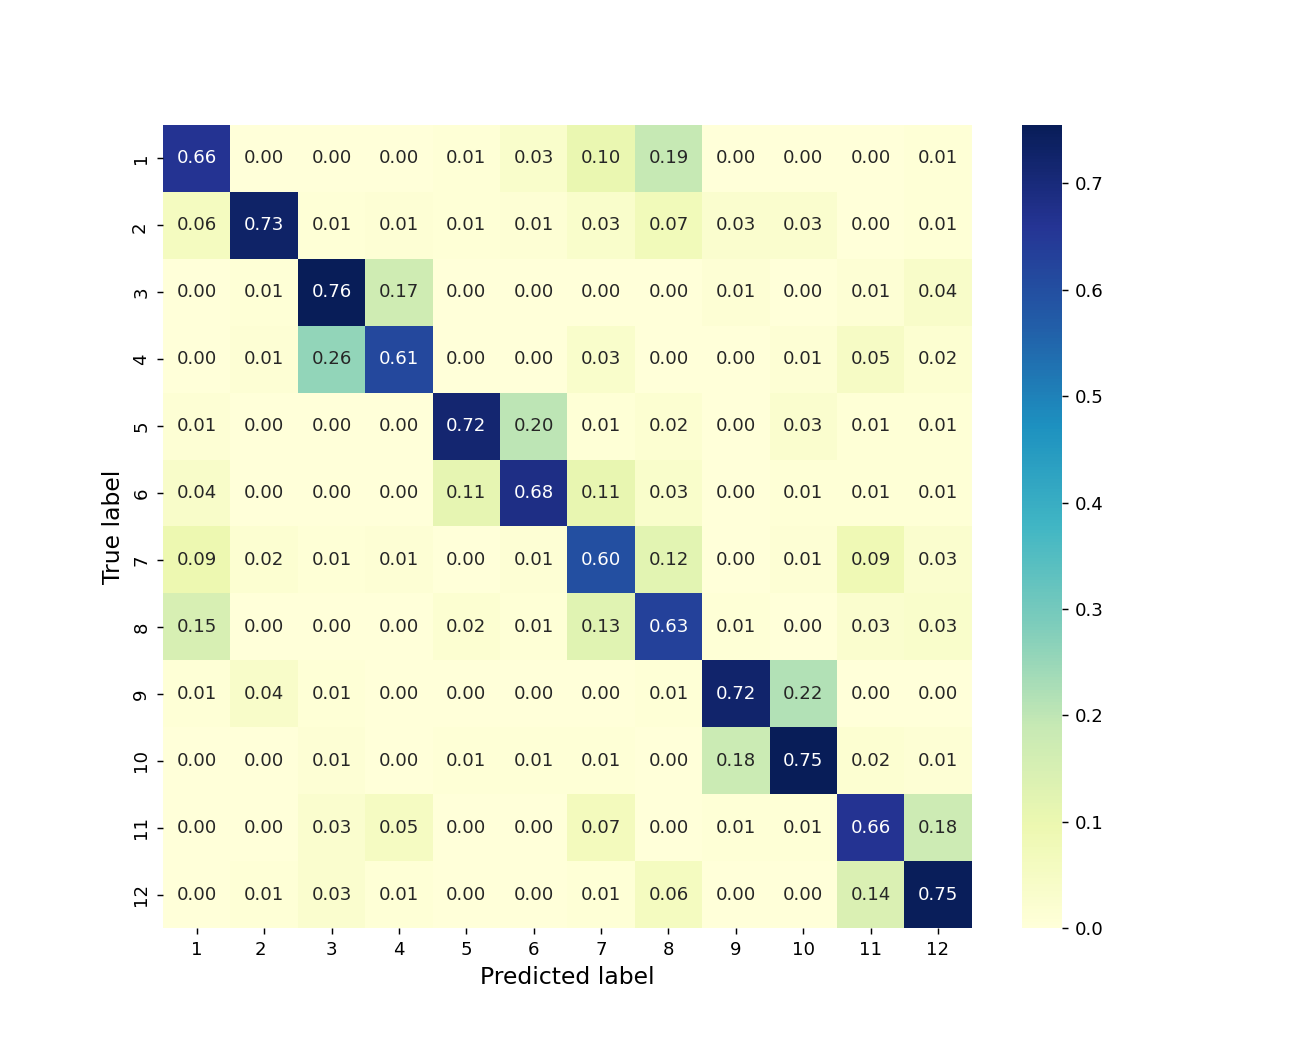

Initializing model: resnet50
Model size: 23.53262M
resnet50_split_by_sub_gyr: Acc@1 70.558 Acc@5 98.534 Acc@10 99.887


<IPython.core.display.Javascript object>


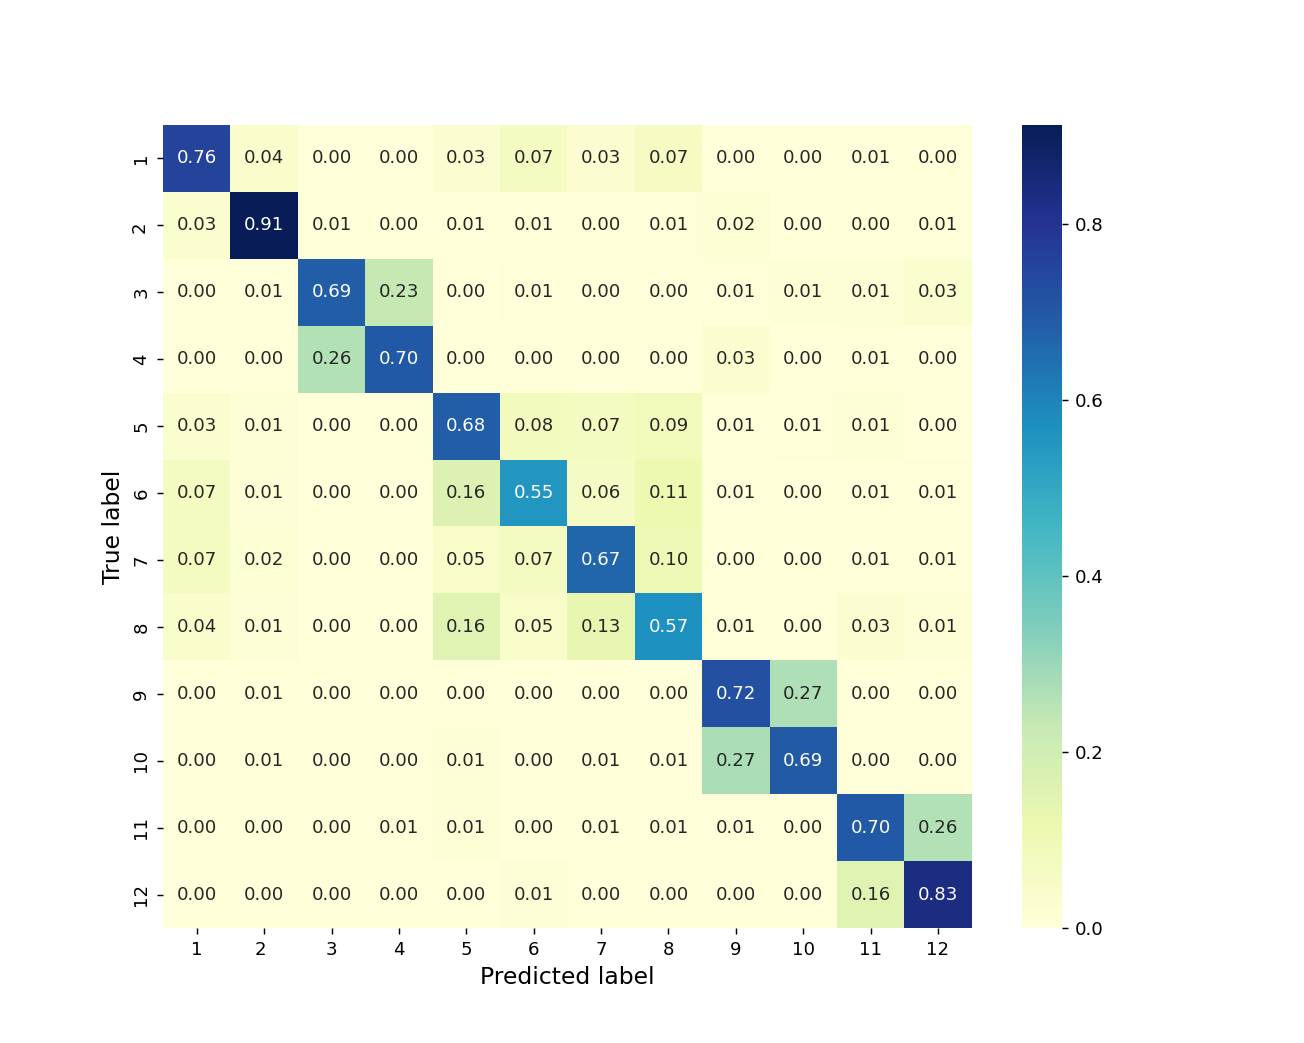

Initializing model: resnet50
Model size: 23.53262M
resnet50_split_by_env_acc: Acc@1 75.901 Acc@5 98.761 Acc@10 99.775


<IPython.core.display.Javascript object>


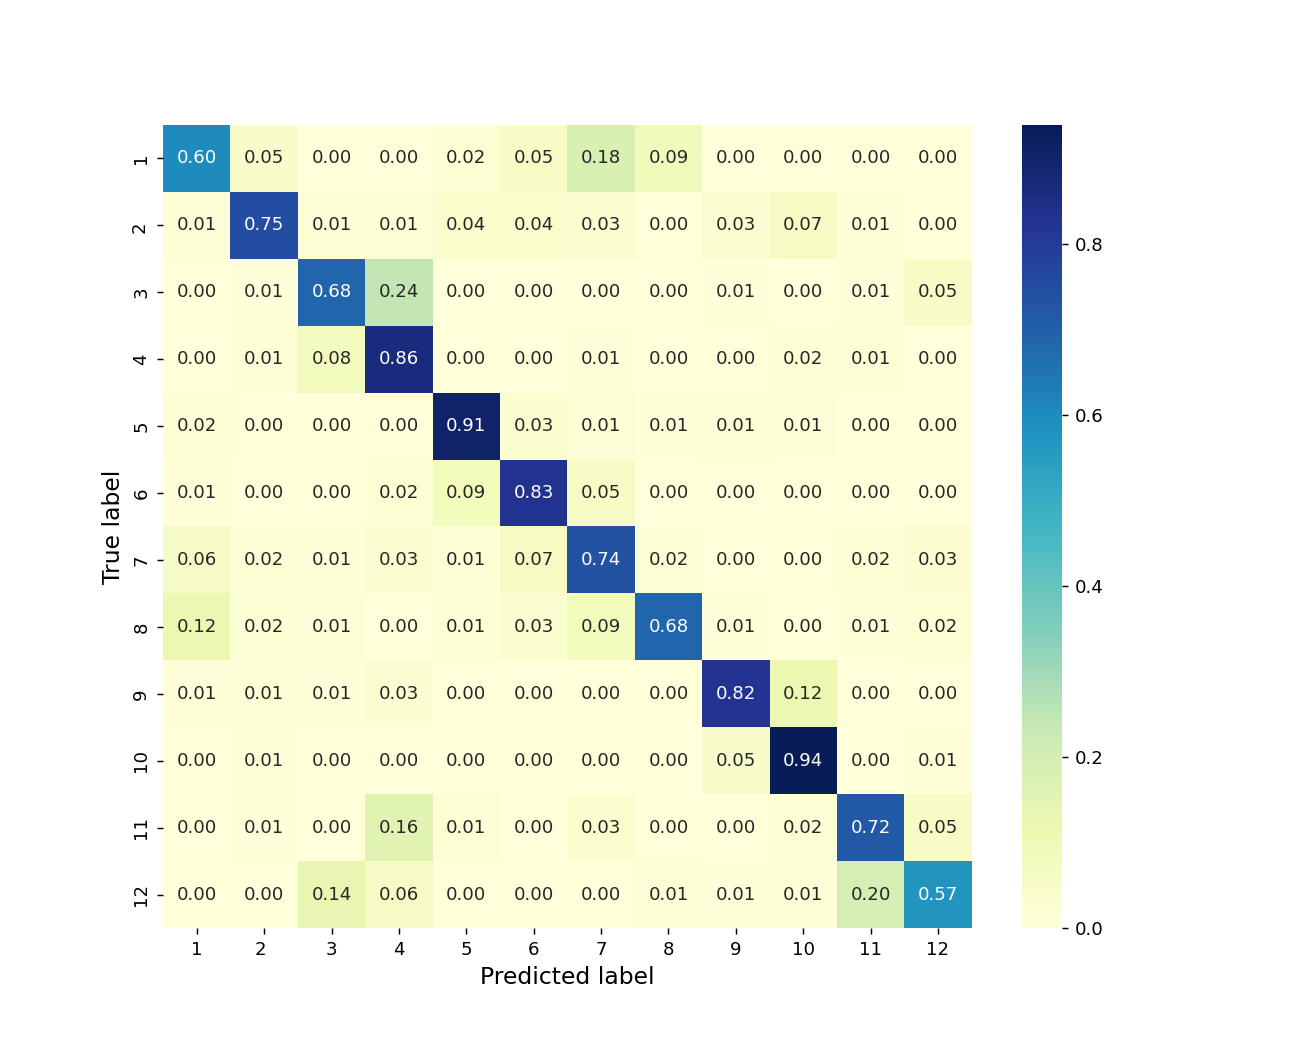

Initializing model: resnet50
Model size: 23.53262M
resnet50_split_by_env_gyr: Acc@1 76.914 Acc@5 98.423 Acc@10 99.944


<IPython.core.display.Javascript object>


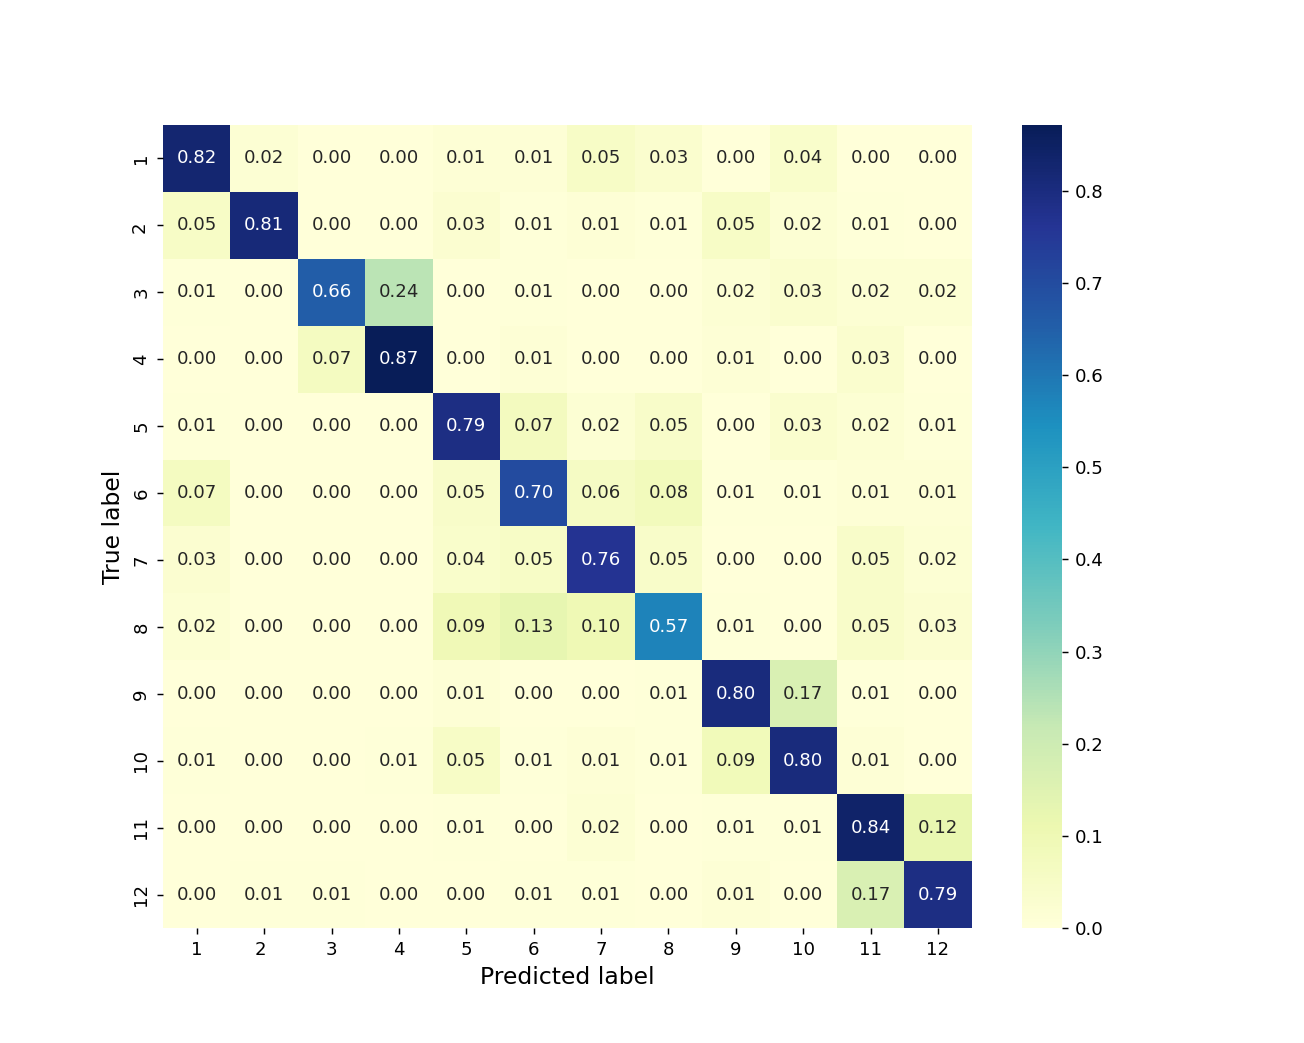

In [8]:
import os
import sys
import numpy as np
import time
import datetime
import os.path as osp
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import models
sys.path.append("libs")  # Adds higher directory to python modules path.
from utils import accuracy, AverageMeter,ProgressMeter, Logger, FusionMatrix 
from dataManager import AfosrDataset
# from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib notebook

for arch in ['resnet18', 'resnet50']:  
    for split  in ['split_by_sub', 'split_by_env']: 
        for signal in ['acc','gyr']:
            data_path='/mnt/works/projectComvis/AFOSR-2020/accelerometer/output/GAF_images_%s' % (signal)
            save_dir='./log/Afosr_2022_GAF_%s/%s_%s' % (signal,arch,split)
            test_list = '/home/nhquan/datasets/afosr2022/%s/val.txt' % (split)
            weightFile=os.path.join(save_dir, 'best_checkpoint.pth.tar')
            test_batch=32
            num_classes=12
            workers=4          
            print_freq=20

            # torch.manual_seed(100)
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

            scaler = transforms.Resize((224,224))
            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])    
            transform= transforms.Compose([
                scaler,
                transforms.ToTensor(),
                normalize       
                ])     

            testDataset = AfosrDataset(data_path,test_list,transform=transform) 
            testLoader = DataLoader(testDataset, batch_size=test_batch, shuffle=False, num_workers=workers)
            print("Initializing model: {}".format(arch))
            model = models.init_model(name=arch, num_classes=num_classes)
            print("Model size: {:.5f}M".format(sum(p.numel() for p in model.parameters())/1000000.0))
            checkpoint = torch.load(weightFile)
            model.load_state_dict(checkpoint['state_dict'], strict=False)
            # model.module.load_state_dict(checkpoint['state_dict'])
            model.eval()
            model.to(device)


#             from ptflops import get_model_complexity_info
#             with torch.cuda.device(0):
#                 flops, params = get_model_complexity_info(model, (3,224,224), as_strings=True, print_per_layer_stat=True, verbose=True)
#                 print('{:<30}  {:<8}'.format('Computational complexity: ', flops))
#                 print('{:<30}  {:<8}'.format('Number of parameters: ', params))


            fusion_matrix = FusionMatrix(num_classes)
            func = torch.nn.Softmax(dim=1)
            top1 = AverageMeter('Acc@1', ':6.3f')
            top5 = AverageMeter('Acc@5', ':6.3f')
            top10 = AverageMeter('Acc@10', ':6.3f')

            with torch.no_grad():
                end = time.time()
                for batch_idx,(imgs, targets) in enumerate(testLoader):
                    imgs, targets = imgs.cuda(device), targets.cuda(device)            
                    outputs, features = model(imgs)
                    result = func(outputs)
            #         _, top_k = result.topk(10, 1, True, True)
                    score_result = result.cpu().numpy()
                    fusion_matrix.update(score_result.argmax(axis=1), targets.cpu().numpy())

                    acc1, acc5,acc10 = accuracy(outputs, targets, topk=(1, 5,10))            
                    top1.update(acc1[0], imgs.size(0))
                    top5.update(acc5[0], imgs.size(0))
                    top10.update(acc10[0], imgs.size(0))
            #         topk_result = top_k.cpu().tolist()                
            #     fig=fusion_matrix.plot_confusion_matrix(normalize = True) 
                    info='%s_%s_%s' % (arch,split,signal)
                print('{info}: Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f} Acc@10 {top10.avg:.3f}'
                      .format(info=info,top1=top1, top5=top5, top10=top10))
            cm=fusion_matrix.matrix.T
            cm=cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]            
            np.savetxt("./%s_%s_%s_confu.csv" % (arch,split,signal), cm, delimiter=",") 
            pdf_file="./%s_%s_%s_confu.pdf" % (arch,split,signal)
            plot_confusion_matrix(cm, class_names=class_names, save_file=pdf_file)
            
#             f=fusion_matrix.plot_confusion_matrix(normalize = False) 
#             f.savefig("%s_%s_%s_confu.pdf" % (arch,split,signal), bbox_inches='tight')

In [7]:

cm=fusion_matrix.matrix.T
cm=cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
np.savetxt("%s_confusion_splitby_env.csv" % (config.project), cm, delimiter=",") 
f=fusion_matrix.plot_confusion_matrix(normalize = False) 
f.savefig("%s_confusion_splitby_env.pdf" % (config.project), bbox_inches='tight')

<IPython.core.display.Javascript object>


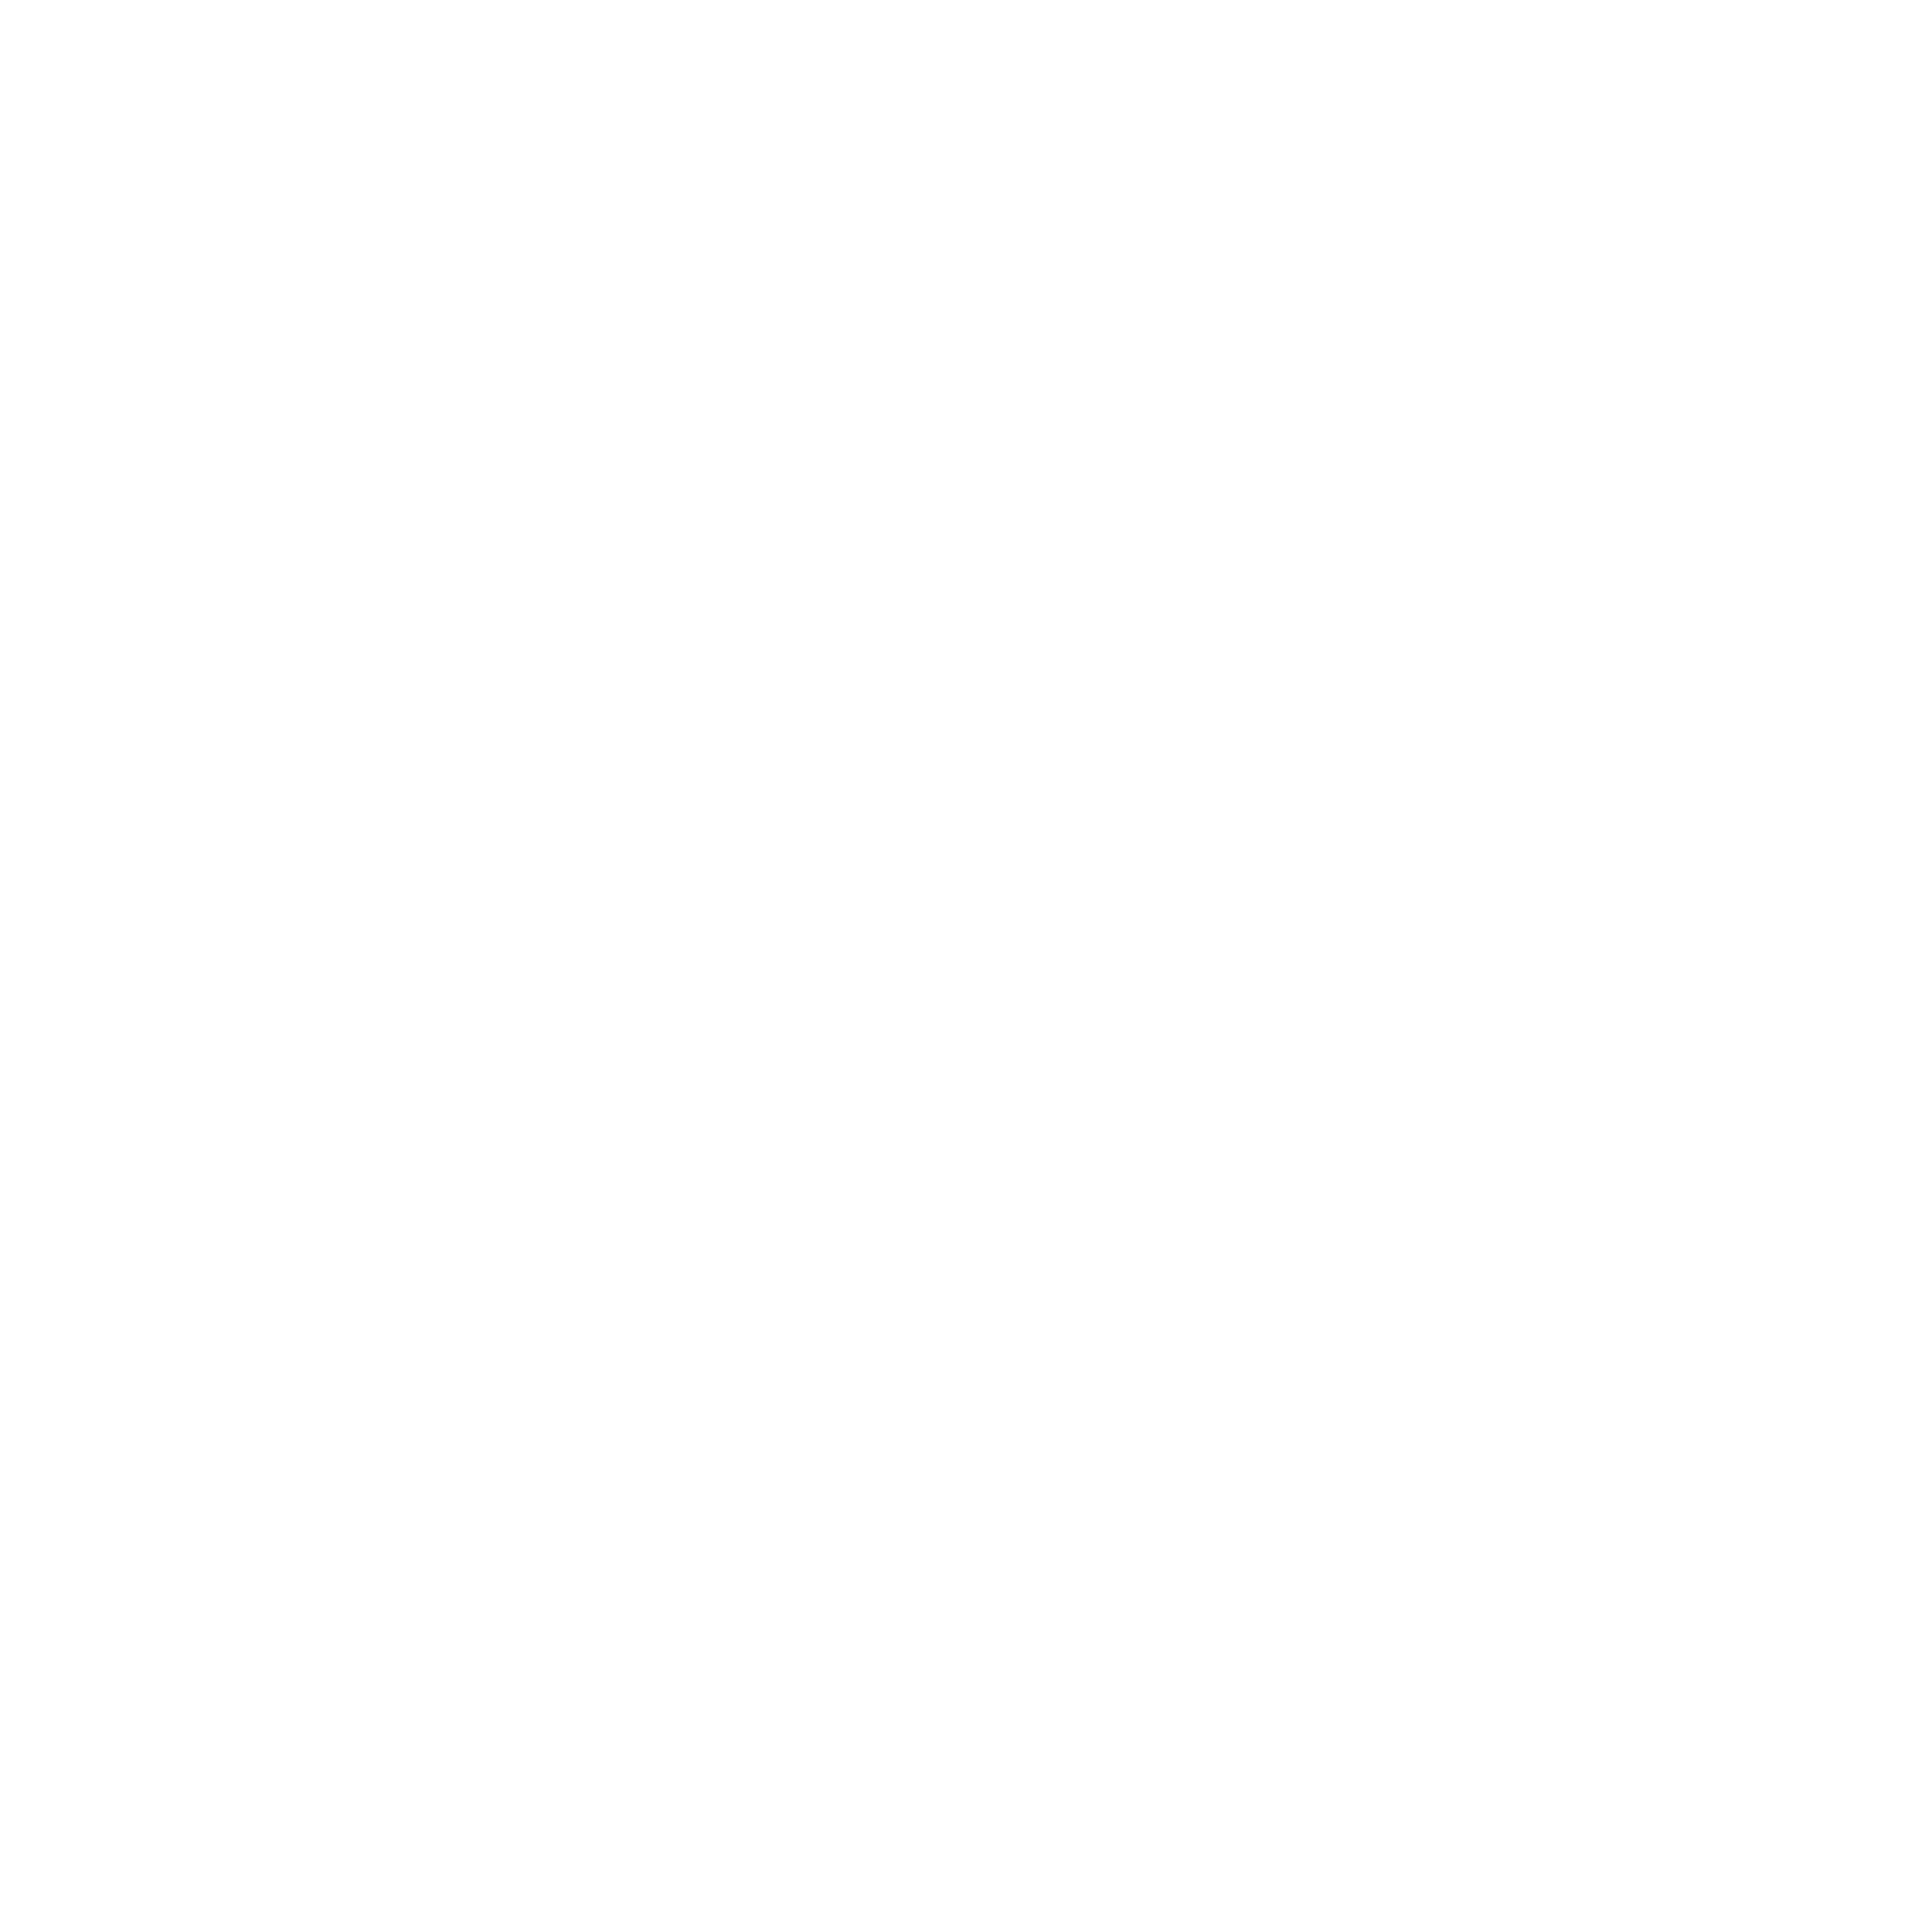

<IPython.core.display.Javascript object>


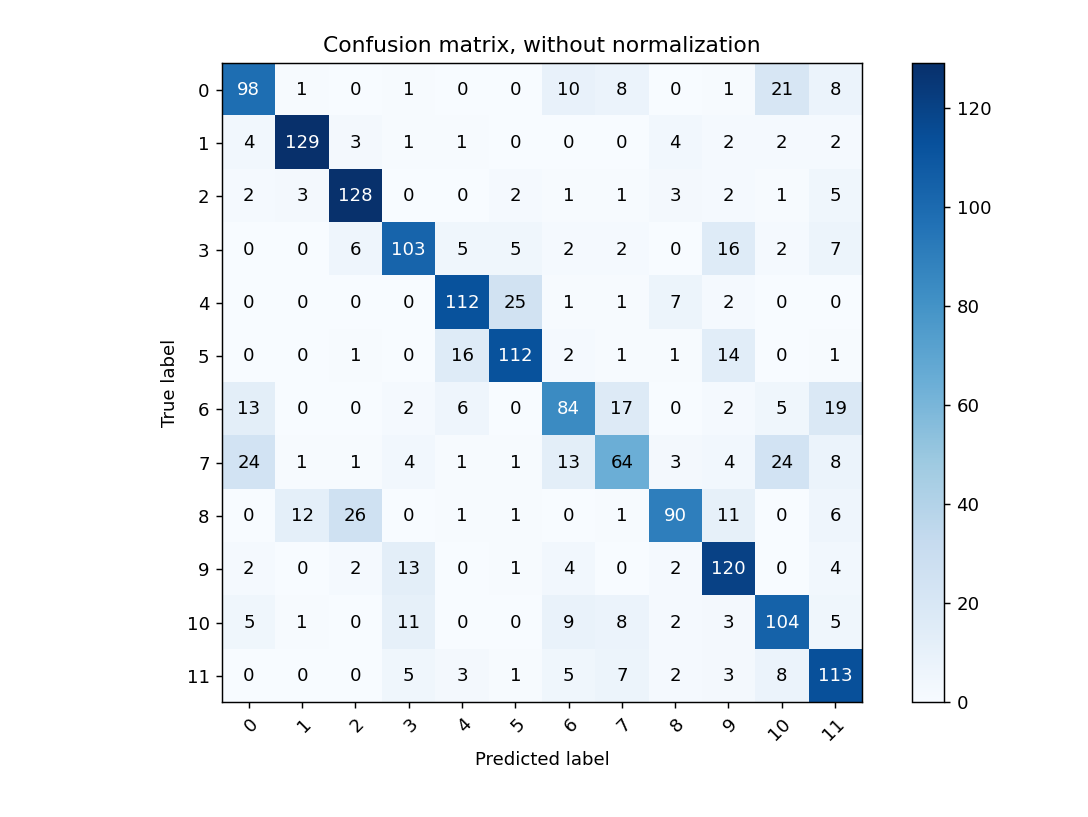